In [1]:
## Install necessary packages if not already installed
## conda installing is very slow, so using pip here
# %pip install matplotlib
# %pip install seaborn
# %pip install rasterstats


In [2]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
from rasterio.transform import Affine

from shapely.geometry import mapping
from rasterio.mask import mask

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import sys, platform
print("=== Environment Info ===")
print(f"Python envi    : {sys.executable}")
print(f"Python version : {sys.version.split()[0]}")
print(f"Platform       : {platform.platform()}")
print(f"rasterio       : {rasterio.__version__}")
print(f"geopandas      : {gpd.__version__}")
print(f"numpy          : {np.__version__}")
print(f"pandas         : {pd.__version__}")
print(f"matplotlib     : {plt.matplotlib.__version__}")
print(f"seaborn        : {sns.__version__}")
print("========================")


=== Environment Info ===
Python envi    : c:\Users\pc\.conda\envs\geo_env\python.exe
Python version : 3.11.13
Platform       : Windows-10-10.0.22631-SP0
rasterio       : 1.3.10
geopandas      : 0.14.4
numpy          : 2.2.6
pandas         : 2.3.2
matplotlib     : 3.10.6
seaborn        : 0.13.2


In [23]:
from pathlib import Path

# Set the working directory
dir_gcm     = Path(r"E:\GCMs") 
dir_ucm_out = dir_gcm / "clip"
out_root = dir_gcm / "clipped"
out_root.mkdir(parents=True, exist_ok=True)

wd_main     = Path(r"G:\Shared drives\Wellcome Trust Project Data") 
wd_shp      = wd_main / "1_preprocess" / "UrbanCoolingModel" / "OfficialWorkingInputs" / "AOIs"
figures_dir = wd_main / "3_final" / "UCM_figures"

admin_shapefile = wd_shp / "London_Borough_aoi.shp"  # Administrative boundary (e.g., census tracts)
# Load administrative boundaries
aoi_adm = gpd.read_file(admin_shapefile)

print(aoi_adm.head())



# in a notebook
from pathlib import Path
curr = Path.cwd()          # current folder
dir_prj = curr.parent       # its parent
print(dir_prj)
dir_fig = dir_prj / "figures"


                   NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  SUB_2006                                           geometry  
0     None  POLYGON ((516401.600 160201.800, 516407.300 16...  
1     None  POLYGON ((535009.200 159504.700, 535005.500 15...  
2     None  POLYGON ((540373.600 157530.400, 540361.200 15...  
3     None  POLYGON ((521975.800 178100.000, 521967.700 17...  
4     None  POLYGON ((510253.500 182881.600, 510249.900 18...  
d:\natcap\urban-cooling-health


### functions

In [4]:
## list all tif files in dir_gcm, excluding certain subdirectories

from pathlib import Path
from typing import List

def list_tifs(dir: Path, include_subfolders: bool = False) -> List[Path]:
    """
    List .tif files in a folder.

    Parameters
    ----------
    dir : Path
        Folder to search.
    include_subfolders : bool, default False
        - False → only files directly under dir
        - True  → recurse into subfolders

    Returns
    -------
    list[Path]
    """
    dir = Path(dir)
    if include_subfolders:
        return sorted([p for p in dir.rglob("*.tif") if p.is_file()])
    else:
        return sorted([p for p in dir.glob("*.tif") if p.is_file()])

## Data

### function - parse file name as prefix

In [59]:
import re
from typing import Tuple, Dict

def parse_worldclim_cmip6_prefix(
    tif_path: str | Path,
    include_var: bool = False
) -> Tuple[str, Dict[str, str]]:
    """
    Extract model, ssp, and period (and var) from a WorldClim CMIP6 tif filename.

    Matches examples like:
      wc2.1_30s_tmax_MRI-ESM2-0_ssp370_2021-2040.tif
      wc2.1_30s_tmax_EC-Earth3-Veg_ssp585_2041-2060.tif
      wc2.1_30s_tmax_MRI-ESM2-0_ssp2-4.5_2021-2040.tif   (also supported)

    Returns:
      prefix (str): 'MODEL_sspXXX[_-X(.X)]_YYYY-YYYY'  (optionally prefixed by var_)
      parts  (dict): {'var','model','ssp','period'}
    """
    name = Path(tif_path).name  # filename only

    # Allow ssp with or without hyphen and optional decimal (ssp585, ssp245, ssp3-7.0, etc.)
    pattern = re.compile(
        r'_(?P<var>tmax|tmin|tx|tn|tas)_'         # variable
        r'(?P<model>.+?)_'                        # model (non-greedy, allows dashes)
        r'(?P<ssp>ssp\d+(?:-\d+(?:\.\d+)?)?)_'    # ssp585 OR ssp3-7.0
        r'(?P<period>\d{4}-\d{4})\.tif$',         # 2041-2060
        flags=re.IGNORECASE
    )

    m = pattern.search(name)
    if not m:
        raise ValueError(f"Filename not recognized: {name}")

    parts: Dict[str, str] = {k: m.group(k) for k in ("var", "model", "ssp", "period")}
    parts["var"] = parts["var"].lower()

    prefix = f"{parts['model']}_{parts['ssp']}_{parts['period']}"
    if include_var:
        prefix = f"{parts['var']}_{prefix}"
    return prefix, parts




import re
from pathlib import Path
from typing import Tuple, Dict

def parse_chelsa_prefix(
    tif_path: str | Path,
    include_var: bool = False
) -> Tuple[str, Dict[str, str]]:
    """
    Parse CHELSA filenames like:
      CHELSA_tasmax_01_2021_V.2.1.tif
      CHELSA_tas_12_1995_V.2.1.tif

    Extracts:
      var     -> tasmax
      month   -> 01
      year    -> 2021
      version -> V.2.1

    Returns:
      prefix:  '2021_01_V.2.1'  or with var → 'tasmax_2021_01_V.2.1'
      parts:   {'var','month','year','version'}
    """
    name = Path(tif_path).name

    pat = re.compile(
        r'^CHELSA_'
        r'(?P<var>[A-Za-z0-9]+)_'     # tasmax / tas / pr / bioXX in some products
        r'(?P<month>\d{2})_'          # 01..12
        r'(?P<year>\d{4})_'           # 2021
        r'(?P<version>V\.\d+\.\d+)'
        r'\.tif$'
    )

    m = pat.match(name)
    if not m:
        raise ValueError(f"CHELSA filename not recognized: {name}")

    parts: Dict[str, str] = {
        "var": m.group("var"),
        "month": m.group("month"),
        "year": m.group("year"),
        "version": m.group("version"),
    }

    prefix = f"{parts['year']}_{parts['month']}_{parts['version']}"
    if include_var:
        prefix = f"{parts['var']}_{prefix}"

    return prefix, parts

# pfx, parts = parse_chelsa_prefix("CHELSA_tasmax_01_2021_V.2.1.tif", include_var=True)
# # pfx  -> 'tasmax_2021_01_V.2.1'
# # parts -> {'var': 'tasmax', 'month': '01', 'year': '2021', 'version': 'V.2.1'}


### input data for viz and comparison 

In [5]:
# --- Step 1: Define File Paths ---
from pathlib import Path


temp1_path = dir_gcm / "wc2.1_30s_tmax_MRI-ESM2-0_ssp370_2021-2040.tif"

temp2_path = dir_gcm / "wc2.1_30s_tmax_MRI-ESM2-0_ssp585_2021-2040.tif"


prefix, _ = parse_worldclim_cmip6_prefix(temp1_path, include_var=True)
print("Parsed prefix:", prefix)

suffix1, _ = parse_worldclim_cmip6_prefix(temp1_path, include_var=True)
suffix2, _ = parse_worldclim_cmip6_prefix(temp2_path, include_var=True)

suffix_change = f"{suffix2}_minus_{suffix1}"
# Define output file path
temp_change_output_path = dir_ucm_out / f"wc2.1_30s_tmax_MRI-ESM2-0_{suffix_change}.tif"
print(temp_change_output_path)



Parsed prefix: tmax_MRI-ESM2-0_ssp370_2021-2040
E:\GCMs\clip\wc2.1_30s_tmax_MRI-ESM2-0_tmax_MRI-ESM2-0_ssp585_2021-2040_minus_tmax_MRI-ESM2-0_ssp370_2021-2040.tif


### function - clip_one_raster

In [62]:
from pathlib import Path
import rasterio
from rasterio.mask import mask

def clip_one_raster(
    in_tif: Path | str,
    clip_gdf,
    out_tif: Path | str | None = None,
    save: bool = True,
    compress: str = "LZW",
    predictor: int | None = None,   # e.g., 2 for floating point, 3 for RGB
    bigtiff: str = "IF_SAFER",      # "NO", "YES", "IF_NEEDED", "IF_SAFER"
    tiled: bool = True,
    blocksize: int = 256,           # tile size (power of 2)
):
    """
    Clip a raster to a polygon GeoDataFrame and (optionally) save to disk.

    Returns:
        (out_path, out_data, out_meta)
        - out_path: Path or None (if save=False)
        - out_data: numpy array (bands, rows, cols)
        - out_meta: dict with raster profile for the clipped data
    """
    in_tif = Path(in_tif)
    with rasterio.open(in_tif) as src:
        # Reproject clip geometry to raster CRS
        clip_geom = clip_gdf.to_crs(src.crs).geometry.values

        out_data, out_transform = mask(
            src, clip_geom, crop=True, nodata=src.nodata, filled=True
        )

        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_data.shape[1],
            "width":  out_data.shape[2],
            "transform": out_transform,
        })

        # Creation options
        # (keep dtype/count/driver, add tiling/compression/bigtiff)
        if tiled:
            out_meta.update({"tiled": True, "blockxsize": blocksize, "blockysize": blocksize})
        if compress:
            out_meta.update({"compress": compress})
        if predictor is not None:
            out_meta.update({"predictor": predictor})
        if bigtiff:
            out_meta.update({"BIGTIFF": bigtiff})

        out_path = None
        if save:
            if out_tif is None:
                out_tif = in_tif.with_name(f"clipped_{in_tif.stem}.tif")
            out_path = Path(out_tif)
            out_path.parent.mkdir(parents=True, exist_ok=True)

            with rasterio.open(out_path, "w", **out_meta) as dst:
                dst.write(out_data)

            # Optional: build overviews for faster display
            try:
                factors = [2, 4, 8, 16]
                dst.build_overviews(factors, rasterio.enums.Resampling.average)
                dst.update_tags(ns="rio_overview", resampling="average", factors=",".join(map(str, factors)))
            except Exception:
                pass

    return out_path, out_data, out_meta


In [7]:
# ---------- helper: clip a raster to AOI and prepare for plotting ----------  # <<< NEW
def clip_raster_to_aoi_for_plot(raster_path, 
                                aoi_gdf, 
                                band=0):
    with rasterio.open(raster_path) as src:
        # Reproject AOI to raster CRS
        aoi_in_raster_crs = aoi_gdf.to_crs(src.crs)
        shapes = [mapping(geom) for geom in aoi_in_raster_crs.geometry if not geom.is_empty]

        # Clip; filled=False returns a masked array -> we can fill NaNs cleanly
        out, out_transform = mask(src, shapes=shapes, crop=True, filled=False)
        meta = src.meta.copy()
        meta.update({
            "height": out.shape[1],
            "width":  out.shape[2],
            "transform": out_transform
        })

        # Use specified band; replace masked pixels with NaN
        arr = out[band].filled(np.nan)

        # Build extent = [left, right, bottom, top] for imshow
        h, w = meta["height"], meta["width"]
        left, top = out_transform * (0, 0)
        right, bottom = out_transform * (w, h)
        extent = [left, right, bottom, top]

        return arr, out_transform, meta, extent

### clip and save

In [8]:
# # 3) Define an output subfolder like outputs/clipped/EC-Earth3-Veg/ssp245/2041-2060

# in_tif = temp1_path  # or temp2_path

# clip_path, clipped_arr, clipped_meta = clip_one_raster(
#     in_tif=in_tif,
#     clip_gdf=aoi_adm,                         # your dissolved London polygon
#     out_tif=out_root / f"{in_tif.stem}_London.tif",
#     save=True, compress="LZW", predictor=2, bigtiff="IF_SAFER", tiled=True
# )
# print("Saved to:", clip_path)



# in_tif = temp2_path  # or temp2_path
# clip_path, clipped_arr, clipped_meta = clip_one_raster(
#     in_tif=in_tif,
#     clip_gdf=aoi_adm,                         # your dissolved London polygon
#     out_tif=out_root / f"{in_tif.stem}_London.tif",
#     save=True, compress="LZW", predictor=2, bigtiff="IF_SAFER", tiled=True
# )
# print("Saved to:", clip_path)

### batch clip 

In [ ]:

# usage
in_list = list_tifs(dir_gcm)
print(f"Found {len(in_list)} tif(s) at top level.")


Found 36 tif(s) at top level.


In [10]:
from typing import Iterable

# --- batch clip helper using your existing clip_one_raster() ---
def batch_clip_worldclim_tifs(
    in_tifs: Iterable[Path],
    out_root: Path,
    clip_gdf,
    include_var_in_name: bool = False,
    compress: str = "LZW",
    predictor: int | None = 2,
    bigtiff: str = "IF_SAFER",
    tiled: bool = True,
    blocksize: int = 256,
) -> list[Path]:
    """
    Clips each input .tif with clip_one_raster() and writes to:
        out_root / <MODEL> / <SSP> / <PERIOD> / <stem>_London.tif
    Returns list of saved paths.
    """
    out_paths = []
    out_root.mkdir(parents=True, exist_ok=True)

    for in_tif in in_tifs:
        # Parse tokens from filename
        _, parts = parse_worldclim_cmip6_prefix(in_tif)
        model, ssp, period = parts["model"], parts["ssp"], parts["period"]

        # # Create subfolder structure
        # subdir = out_root / model / ssp / period
        # subdir.mkdir(parents=True, exist_ok=True)

        # Build output filename (optionally include var prefix)
        var_prefix = f"{parts['var']}_" if include_var_in_name else ""
        out_tif = out_root / f"{var_prefix}{Path(in_tif).stem}_London.tif"

        # Clip & save
        clip_path, _, _ = clip_one_raster(
            in_tif=in_tif,
            clip_gdf=clip_gdf,
            out_tif=out_tif,
            save=True,
            compress=compress,
            predictor=predictor,
            bigtiff=bigtiff,
            tiled=tiled,
            blocksize=blocksize,
        )
        print("✓ Saved:", clip_path)
        out_paths.append(clip_path)

    return out_paths

# -----------------------------
# Example usage with your vars
# -----------------------------

saved = batch_clip_worldclim_tifs(
    in_tifs=in_list,
    out_root=out_root,
    clip_gdf=aoi_adm,           # your dissolved London polygon GeoDataFrame
    include_var_in_name=False,  # set True if you want 'tmax_' prefixed
)

✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp245_2021-2040_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp245_2041-2060_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp245_2061-2080_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp245_2081-2100_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp370_2021-2040_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp370_2041-2060_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp370_2061-2080_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp370_2081-2100_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp585_2021-2040_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp585_2041-2060_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp585_2061-2080_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp585_2081-2100_London.tif
✓ Saved: E:\GCMs\clipped\wc2.1_30s_tmax_IPSL-CM6A-LR

### batch CHELSA

In [38]:
## fucntion 

from typing import Iterable

# --- batch clip helper using your existing clip_one_raster() ---
def batch_clip_chelsa_tifs(
    in_tifs: Iterable[Path],
    out_root: Path,
    clip_gdf,
    include_var_in_name: bool = False,
    compress: str = "LZW",
    predictor: int | None = 2,
    bigtiff: str = "IF_SAFER",
    tiled: bool = True,
    blocksize: int = 256,
) -> list[Path]:
    """
    Clips each input .tif with clip_one_raster() and writes to:
        out_root / <MODEL> / <SSP> / <PERIOD> / <stem>_London.tif
    Returns list of saved paths.
    """
    out_paths = []
    out_root.mkdir(parents=True, exist_ok=True)

    for in_tif in in_tifs:
        # Parse tokens from filename
        _, parts = parse_chelsa_prefix(in_tif)
        month, year, version = parts["month"], parts["year"], parts["version"]

        # # Create subfolder structure
        # subdir = out_root / model / ssp / period
        # subdir.mkdir(parents=True, exist_ok=True)

        # Build output filename (optionally include var prefix)
        var_prefix = f"{parts['var']}_" if include_var_in_name else ""
        out_tif = out_root / f"{var_prefix}{Path(in_tif).stem}_London.tif"

        # Clip & save
        clip_path, _, _ = clip_one_raster(
            in_tif=in_tif,
            clip_gdf=clip_gdf,
            out_tif=out_tif,
            save=True,
            compress=compress,
            predictor=predictor,
            bigtiff=bigtiff,
            tiled=tiled,
            blocksize=blocksize,
        )
        print("✓ Saved:", clip_path)
        out_paths.append(clip_path)

    return out_paths

# -----------------------------

# usage
dir_chelsa = Path(r"E:\chelsa02\chelsa\global\monthly\tasmax")  # adjust if needed
in_list = list_tifs(dir_chelsa, include_subfolders=True)
print(f"Found {len(in_list)} tif(s) at top level.")
out_chelsa = Path(r"E:\chelsa02\clipped_london")


Found 144 tif(s) at top level.


In [ ]:

saved = batch_clip_chelsa_tifs(
    in_tifs=in_list,
    out_root=out_chelsa,
    clip_gdf=aoi_adm,           # your dissolved London polygon GeoDataFrame
    include_var_in_name=False,  # set True if you want 'tmax_' prefixed
)

# Viz / Plot

### Function - plot by month 

In [34]:
import sys
import os
cwd = os.getcwd()
print(cwd)
# 1) add current folder (where function_make_map_scale.py lives)
sys.path.append(os.getcwd())

# 2) import the module
import function_make_map_scale

d:\natcap\urban-cooling-health\code


In [43]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_worldclim_multiband_temp(
    in_tif,
    cmap="turbo",              # good sequential temperature map
    diverging=False,           # set True to center at 0 °C with a diverging map
    diverging_cmap="RdBu_r",   # used when diverging=True
    vmin=None, vmax=None,      # set to lock color limits; otherwise auto from data
    months_labels=("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"),
    title_prefix="Temperature (°C)",
    save_png=None,             # e.g., "tx_ECEarth3Veg_London.png"
    show_plot=True,
):
    """
    Visualize a 12-band WorldClim CMIP6 raster (Jan–Dec) with a temperature-friendly colormap.

    Parameters
    ----------
    in_tif : str or Path
        Path to the multi-band (12 bands) GeoTIFF.
    cmap : str
        Matplotlib colormap name for sequential plotting (e.g., "turbo", "plasma", "magma").
    diverging : bool
        If True, uses a diverging map centered on 0 °C (freezing).
    diverging_cmap : str
        Matplotlib colormap name for diverging plotting (e.g., "RdBu_r", "coolwarm", "Spectral_r").
    vmin, vmax : float or None
        Global color limits. If None, computed from all bands.
    months_labels : iterable of str
        Labels for the 12 months.
    title_prefix : str
        Prefix for subplot titles.
    save_png : str or Path or None
        If provided, saves the figure to this path.
    """
    with rasterio.open(in_tif) as src:
        if src.count < 12:
            raise ValueError(f"Expected 12 bands, found {src.count} in {in_tif}")

        # Read all bands into memory for consistent scaling
        data = src.read()  # shape: (12, rows, cols)
        # Mask nodata
        nodata = src.nodata
        if nodata is not None:
            data = np.where(data == nodata, np.nan, data)

        # Global min/max across months (ignoring NaNs) if not user-specified
        if vmin is None:
            vmin = np.nanmin(data)
        if vmax is None:
            vmax = np.nanmax(data)

        # Choose normalization
        norm = None
        cmap_to_use = cmap
        if diverging:
            cmap_to_use = diverging_cmap
            # Center color scale on 0 °C; expand to include vmin/vmax
            lower = min(vmin, 0.0)
            upper = max(vmax, 0.0)
            norm = TwoSlopeNorm(vmin=lower, vcenter=0.0, vmax=upper)

        # Plot
        fig, axes = plt.subplots(3, 4, figsize=(10, 4), constrained_layout=True)
        axes = axes.ravel()

        last_im = None
        for b in range(12):
            ax = axes[b]
            arr = data[b, :, :]
            im = ax.imshow(
                arr,
                extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top),
                cmap=cmap_to_use,
                vmin=vmin if not diverging else None,
                vmax=vmax if not diverging else None,
                norm=norm if diverging else None,
                origin="upper",
                interpolation="nearest",
            )
            ax.set_title(f"{months_labels[b]}")
            ax.set_xticks([]); ax.set_yticks([])
            last_im = im

        # One shared colorbar
        cbar = fig.colorbar(last_im, ax=axes, shrink=0.85)
        cbar.set_label("°C")

        fig.suptitle(f"{title_prefix}", fontsize=14)

        if save_png:
            fig.savefig(save_png, dpi=200)
            print(f"Saved figure to: {save_png}")
        if show_plot:
            plt.show()

# Examples:
# 1) Sequential (good default for tas/tx/tn that stay > 0 °C)
# plot_worldclim_multiband_temp("tx_ECEarth3Veg_ssp245_2041-2060_London.tif", cmap="turbo")

# 2) Diverging centered on 0 °C (useful for tn or tas crossing freezing)
# plot_worldclim_multiband_temp("tn_MRI-ESM2-0_ssp370_2021-2040_London.tif",
#                               diverging=True, diverging_cmap="RdBu_r")


### Example

In [ ]:
import rasterio

# in_tif = temp1_path
# f = out_root / f"{in_tif.stem}_London.tif"; print(f)
# with rasterio.open(f) as src:
#     print("Band count:", src.count)


# # Examples:
# # 1) Sequential (good default for tas/tx/tn that stay > 0 °C)
# plot_worldclim_multiband_temp(f, cmap="RdBu_r", show_plot= False)


# in_tif = temp2_path
# f = out_root / f"{in_tif.stem}_London.tif"
# with rasterio.open(f) as src:
#     print("Band count:", src.count)


# # Examples:
# # 1) Sequential (good default for tas/tx/tn that stay > 0 °C)
# plot_worldclim_multiband_temp(f, cmap="RdBu_r")


### plot monthly map for all models * ssps

In [ ]:


## loop plot and save as png
for in_tif in saved:
    f = in_tif
    with rasterio.open(f) as src:
        print("Band count:", src.count)
    
    out_png = dir_gcm / 'figures' / f"{in_tif.stem}.png"
    plot_worldclim_multiband_temp(
        f, 
        cmap="RdBu_r", 
        diverging=False, 
        save_png=out_png,
        show_plot=False
    )

### viz one selected result

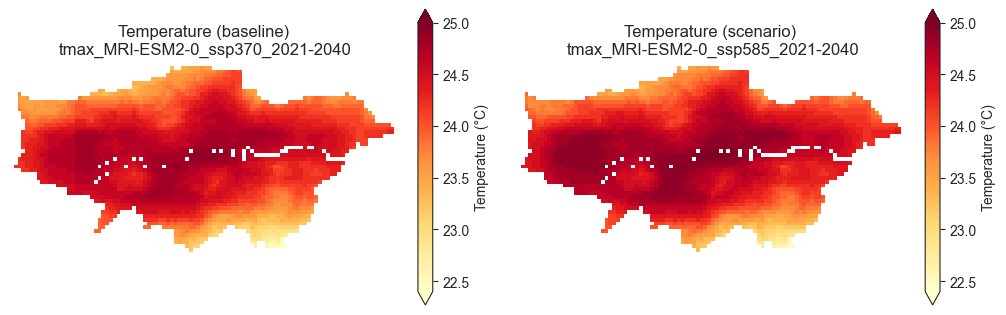

In [ ]:
sns.set_style("white")  # 'whitegrid', 'darkgrid', etc. also available

band_to_plot = 7  # July (1-based index)

# --- Step 2: Load, CLIP, and Visualize the Two Temperature Maps ---

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# CLIP to AOI instead of reading the full rasters
temp1, t1_transform, t1_meta, extent = clip_raster_to_aoi_for_plot(temp1_path, aoi_adm, band=band_to_plot) 
temp2, t2_transform, t2_meta, _      = clip_raster_to_aoi_for_plot(temp2_path, aoi_adm, band=band_to_plot) 

# Get common vmin and vmax (excluding NaNs)
combined = np.concatenate([temp1.ravel(), temp2.ravel()])
combined = combined[~np.isnan(combined)]
vmin, vmax = np.nanmin(combined), np.nanmax(combined)

# Plot the first temperature map (already clipped)
im1 = axes[0].imshow(temp1, cmap="YlOrRd", vmin=vmin, vmax=vmax, extent=extent, origin="upper")
axes[0].set_title(f"Temperature (baseline) \n{suffix1}")
axes[0].set_axis_off()
plt.colorbar(im1, ax=axes[0], label="Temperature (°C)", extend='both', fraction=0.035, pad=0.04)

# Plot the second temperature map (already clipped)
im2 = axes[1].imshow(temp2, cmap="YlOrRd", vmin=vmin, vmax=vmax, extent=extent, origin="upper")
axes[1].set_title(f"Temperature (scenario) \n{suffix2}")
axes[1].set_axis_off()
plt.colorbar(im2, ax=axes[1], label="Temperature (°C)", extend='both', fraction=0.035, pad=0.04)

# Save the figure
f = f"gcm_{suffix_change}_{band_to_plot}.png"
output_plot_path = dir_gcm / 'figures' / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)
plt.show()


In [ ]:
# Flatten the array and remove NaN values
temp_flat = temp1.ravel()
temp_flat = temp_flat[np.isfinite(temp_flat)]  # Remove NaNs

# Summary Statistics
summary_stats = pd.Series(temp_flat).describe(percentiles=[0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
 count    2932.000000
mean       24.248907
std         0.456301
min        22.400000
0%         22.400000
5%         23.400000
10%        23.600000
25%        24.000000
50%        24.299999
75%        24.600000
90%        24.700001
95%        24.799999
99%        24.799999
100%       24.900000
max        24.900000
dtype: float64


## Plot - worldclim

In [ ]:
import math
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import re

# (Optional) nice labels from filename
def parse_worldclim_cmip6_prefix(tif_path):
    name = Path(tif_path).name
    m = re.search(
        r'_(?P<var>tmax|tmin|tx|tn|tas)_(?P<model>.+?)_(?P<ssp>ssp[\d\-\.]+)_(?P<period>\d{4}-\d{4})\.tif$',
        name, flags=re.IGNORECASE
    )
    if m:
        g = m.groupdict()
        return f"{g['model']} · {g['ssp']} · {g['period']}"
    return Path(tif_path).stem

def read_band_as_array(path, band_index=7):
    """
    Read a given band from a multi-band GeoTIFF as float with NaNs for NoData.
    """
    with rasterio.open(path) as src:
        if src.count < band_index:
            raise ValueError(f"{path} has only {src.count} band(s); expected >= {band_index}.")
        arr = src.read(band_index).astype("float32")
        if src.nodata is not None:
            arr[arr == src.nodata] = np.nan
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        return arr, extent

def plot_july_across_models(
    tif_paths,
    cmap="turbo",               # good sequential temp map
    vmin=None, vmax=None,       # set for fixed scale; if None, compute from data
    ncols=3,                    # number of columns in the panel
    title="July temperature (°C)",
    save_png=None,              # e.g., Path("july_all_models.png")
):
    tif_paths = [Path(p) for p in tif_paths]
    # 1) Read July (band 7) arrays + extents, and compute global vmin/vmax if needed
    arrays, extents, labels = [], [], []
    for p in tif_paths:
        arr, ext = read_band_as_array(p, band_index=7)  # July = band 7
        arrays.append(arr)
        extents.append(ext)
        labels.append(parse_worldclim_cmip6_prefix(p))

    if vmin is None or vmax is None:
        stack = np.stack([np.nan_to_num(a, nan=np.nan) for a in arrays], axis=0)
        vmin = np.nanmin(stack) if vmin is None else vmin
        vmax = np.nanmax(stack) if vmax is None else vmax
        # guard against degenerate ranges
        if np.isclose(vmin, vmax):
            vmax = vmin + 1e-6

    # 2) Layout
    n = len(arrays)
    ncols = max(1, ncols)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 2.5*nrows), constrained_layout=True)
    if isinstance(axes, np.ndarray):
        axes = axes.ravel()
    else:
        axes = [axes]

    last_im = None
    for i, (arr, ext, label) in enumerate(zip(arrays, extents, labels)):
        ax = axes[i]
        im = ax.imshow(arr, extent=ext, cmap=cmap, vmin=vmin, vmax=vmax, origin="upper", interpolation="nearest")
        ax.set_title(label, fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        last_im = im

    # Hide unused subplots if any
    for j in range(n, len(axes)):
        axes[j].axis("off")

    # Shared colorbar
    cbar = fig.colorbar(last_im, ax=[a for a in axes if a.has_data()], shrink=0.85)
    cbar.set_label("°C")
    fig.suptitle(title, fontsize=14)

    if save_png:
        save_png = Path(save_png)
        save_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_png, dpi=200)
        print(f"Saved July panel to: {save_png}")

    plt.show()


### clipped raster list

In [41]:

# -------------------------
# Example usage
# -------------------------
# Suppose your clipped outputs are under dir_gcm / "clipped" recursively
dir_clipped = dir_gcm / "clipped"

# tifs = sorted([p for p in dir_clipped.rglob("*.tif")])
## use the earlier defined function to list tifs at top level
tifs = list_tifs(dir_clipped)

# print each tif
for t in tifs:
    print(t)


# # Plot July across all models with a shared global scale
# plot_july_across_models(
#     tifs,
#     cmap="turbo",           # or "plasma"
#     vmin=None, vmax=None,   # let code compute global min/max across all models
#     ncols=4,
#     title="London · July (band 7) · WorldClim CMIP6 clipped",
#     save_png= dir_gcm / "figures" / "july_all_models.png",
# )


E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp245_2021-2040_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp245_2041-2060_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp245_2061-2080_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp245_2081-2100_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp370_2021-2040_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp370_2041-2060_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp370_2061-2080_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp370_2081-2100_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp585_2021-2040_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp585_2041-2060_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp585_2061-2080_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp585_2081-2100_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_IPSL-CM6A-LR_ssp245_2021-2040_London.tif
E:\GCMs\clipped\wc2.1_30s_tmax_IPSL-CM6A-LR_ssp245_2041-2060_London.tif
E:\GCMs\clipped\

### plot - sorted by year, ssp, and model

#### function 

In [46]:
from pathlib import Path
import math
import re
import numpy as np
import rasterio
import matplotlib.pyplot as plt

import re
from pathlib import Path

# preferred SSP order for sorting
_SSP_ORDER = ["ssp126", "ssp245", "ssp370", "ssp585"]

def parse_worldclim_parts(tif_path: str | Path) -> dict:
    """
    Parse var, model, ssp, period from WorldClim CMIP6 filenames such as:
      wc2.1_30s_tmax_EC-Earth3-Veg_ssp585_2041-2060.tif
      wc2.1_30s_tmax_EC-Earth3-Veg_ssp585_2041-2060_London.tif   (extra suffix ok)
    Returns dict with keys: var, model, ssp, period, period_start, ssp_canon, label
    """
    name = Path(tif_path).name

    # allow optional tail like "_London" (anything without a dot) before ".tif"
    pat = re.compile(
        r'wc2\.1_30s_'
        r'(?P<var>tmax|tmin|tx|tn|tas)_'
        r'(?P<model>.+?)_'
        r'(?P<ssp>ssp\d+(?:-\d+(?:\.\d+)?)?)_'
        r'(?P<period>\d{4}-\d{4})'
        r'(?:_[^.]+)?\.tif$',       # <- optional suffix like _London
        flags=re.IGNORECASE
    )

    m = pat.search(name)
    if not m:
        # fallback: looser match ignoring the wc2.1_30s_ prefix entirely
        pat2 = re.compile(
            r'_(?P<var>tmax|tmin|tx|tn|tas)_'
            r'(?P<model>.+?)_'
            r'(?P<ssp>ssp\d+(?:-\d+(?:\.\d+)?)?)_'
            r'(?P<period>\d{4}-\d{4})'
            r'(?:_[^.]+)?\.tif$', flags=re.IGNORECASE
        )
        m = pat2.search(name)
    if not m:
        raise ValueError(f"Unrecognized filename: {name}")

    g = m.groupdict()
    ssp_canon = g["ssp"].lower().replace("-", "")   # e.g., ssp3-7.0 -> ssp370
    period_start = int(g["period"].split("-")[0])
    label = f"{g['model']} · {g['ssp']} · {g['period']}"
    return {
        "var": g["var"].lower(),
        "model": g["model"],
        "ssp": g["ssp"],
        "ssp_canon": ssp_canon,
        "period": g["period"],
        "period_start": period_start,
        "label": label,
    }



def sort_key(parts: dict):
    """
    Build a tuple key for sorting parsed WorldClim/CMIP6 filenames.

    Ordering logic (lowest → highest):
      1) period_start (e.g., 2021 < 2041 < 2061 < 2081)
      2) SSP (by preferred order _SSP_ORDER; unknown SSPs go last)
      3) model (alphabetical tie-breaker)

    Parameters
    ----------
    parts : dict
        A dict produced by your filename parser, expected to include:
          - "period_start" : int      (e.g., 2021, 2041, 2061, 2081)
          - "ssp_canon"    : str      (e.g., 'ssp126','ssp245','ssp370','ssp585')
          - "model"        : str      (e.g., 'EC-Earth3-Veg')

    Returns
    -------
    tuple
        (period_start, ssp_rank, model) suitable for list.sort(key=...) or sorted(..., key=...).
    """
    # Rank SSP by preferred order; if not found, push to the end with a large rank.
    ssp_idx = _SSP_ORDER.index(parts["ssp_canon"]) if parts["ssp_canon"] in _SSP_ORDER else 999

    # Period start year; default to a very large number if missing so it sorts last.
    period_start = int(parts.get("period_start", 10_000))

    # Model name as final alphabetical tie-breaker.
    model = str(parts.get("model", ""))

    ## order 1: period_start, order 2: ssp_idx, order 3: model
    # return (period_start, ssp_idx, model)

    ## order 1: ssp_idx, order 2: period_start, order 3: model
    return (model, period_start, ssp_idx)


def read_band_as_array(path: Path, band_index=7):
    with rasterio.open(path) as src:
        if src.count < band_index:
            raise ValueError(f"{path.name} has {src.count} band(s); expected ≥ {band_index}.")
        arr = src.read(band_index).astype("float32")
        if src.nodata is not None:
            arr[arr == src.nodata] = np.nan
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    return arr, extent

# ---- main plotting ----
def plot_july_sorted_by_ssp_year_model(
    tif_paths,
    ncols=3,
    cmap="turbo",
    vmin=None, vmax=None,
    title="London · July (band 7) · WorldClim CMIP6 clipped",
    save_png=None,
):
    tif_paths = [Path(p) for p in tif_paths]

    # Parse & sort
    parsed = []
    for p in tif_paths:
        parts = parse_worldclim_parts(p)
        parsed.append((p, parts))
    parsed.sort(key=lambda x: sort_key(x[1]))

    # Read arrays and compute global vmin/vmax if not provided
    arrays, extents, labels = [], [], []
    for p, parts in parsed:
        arr, ext = read_band_as_array(p, band_index=7)  # July
        arrays.append(arr); extents.append(ext); labels.append(parts["label"])

    if vmin is None or vmax is None:
        stack = np.stack([a for a in arrays], axis=0)
        vmin = np.nanmin(stack) if vmin is None else vmin
        vmax = np.nanmax(stack) if vmax is None else vmax
        if np.isclose(vmin, vmax):
            vmax = vmin + 1e-6

    # Grid
    n = len(arrays)
    ncols = max(1, ncols)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 2.5*nrows), constrained_layout=True)
    axes = axes.ravel() if hasattr(axes, "ravel") else [axes]

    last_im = None
    for i, (arr, ext, label) in enumerate(zip(arrays, extents, labels)):
        ax = axes[i]
        im = ax.imshow(arr, extent=ext, cmap=cmap, vmin=vmin, vmax=vmax,
                       origin="upper", interpolation="nearest")
        ax.set_title(label, fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        last_im = im

    # hide unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    # shared colorbar
    cbar = fig.colorbar(last_im, ax=[a for a in axes if a.has_data()], shrink=0.85)
    cbar.set_label("°C")
    fig.suptitle(title, fontsize=14)

    if save_png:
        save_png = Path(save_png)
        save_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_png, dpi=200)
        print("Saved:", save_png)

    plt.show()

#### plot maps

Saved: E:\GCMs\figures\july_all_models_sorted.png


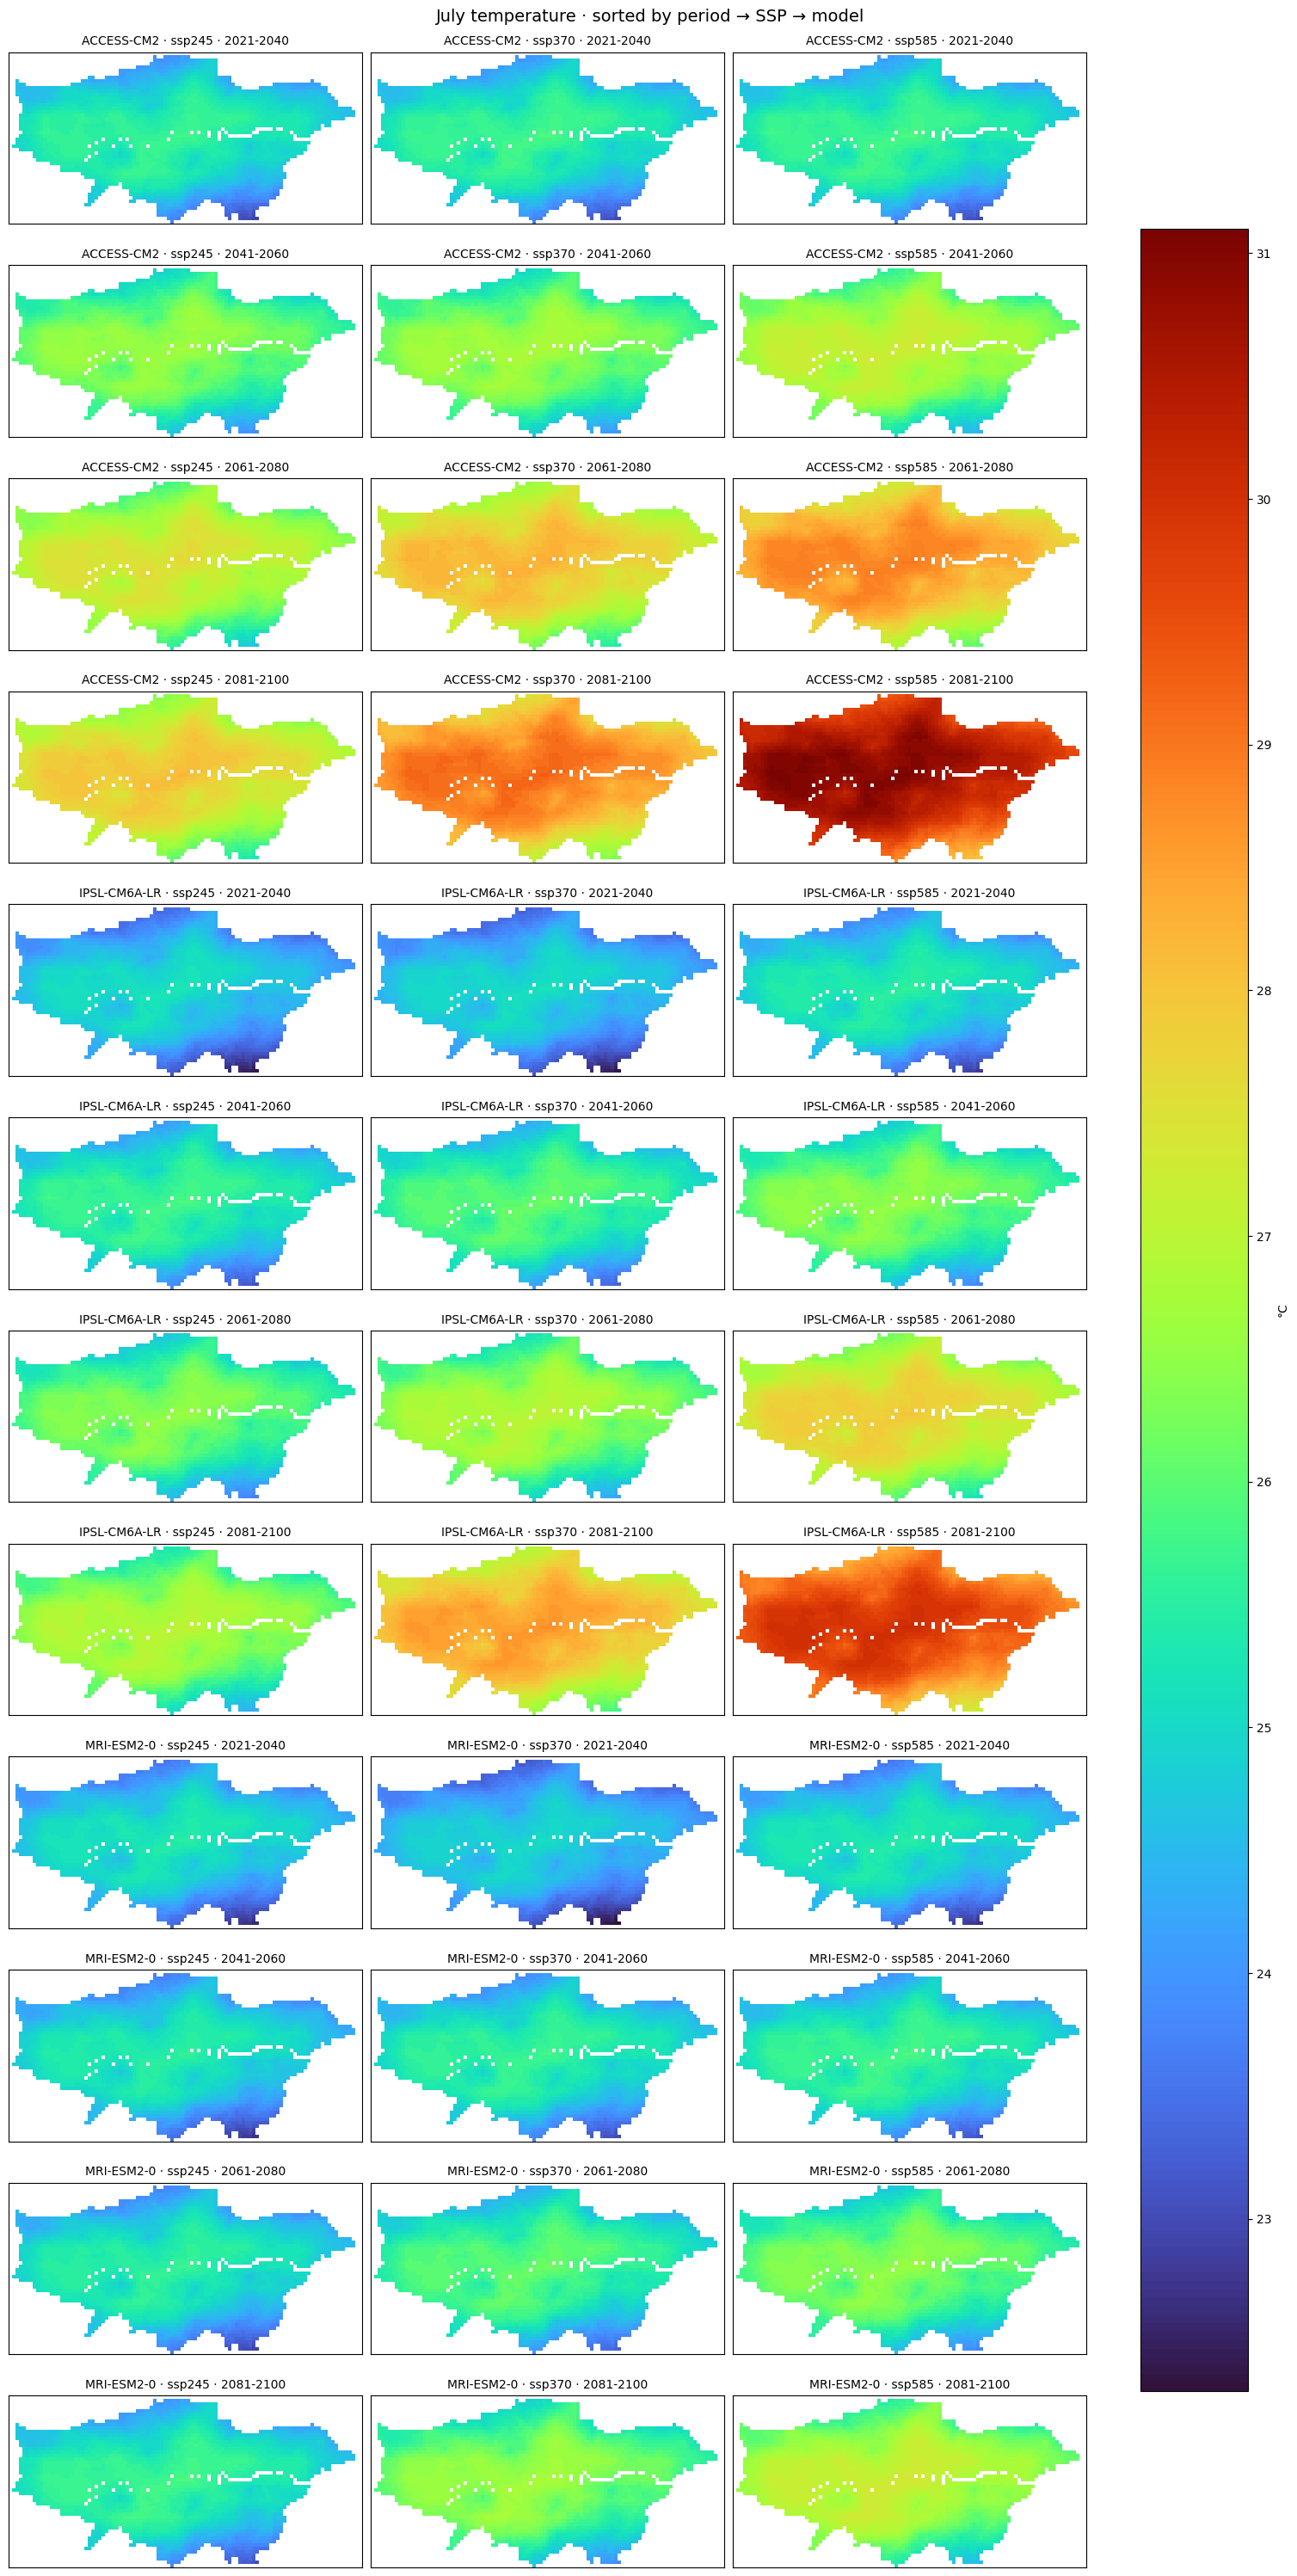

In [ ]:

plot_july_sorted_by_ssp_year_model(
    tifs,
    ncols=3,
    cmap="turbo",           # or "plasma"
    vmin=None, vmax=None,
    title="July temperature · sorted by period → SSP → model",
    save_png=dir_gcm/ "figures" / "july_all_models_sorted.png",
)


#### plot - selected ssp and year

[WindowsPath('E:/GCMs/clipped/wc2.1_30s_tmax_ACCESS-CM2_ssp370_2041-2060_London.tif'), WindowsPath('E:/GCMs/clipped/wc2.1_30s_tmax_IPSL-CM6A-LR_ssp370_2041-2060_London.tif'), WindowsPath('E:/GCMs/clipped/wc2.1_30s_tmax_MRI-ESM2-0_ssp370_2041-2060_London.tif')]
Saved: E:\GCMs\figures\july_all_models_sorted_ssp370.png


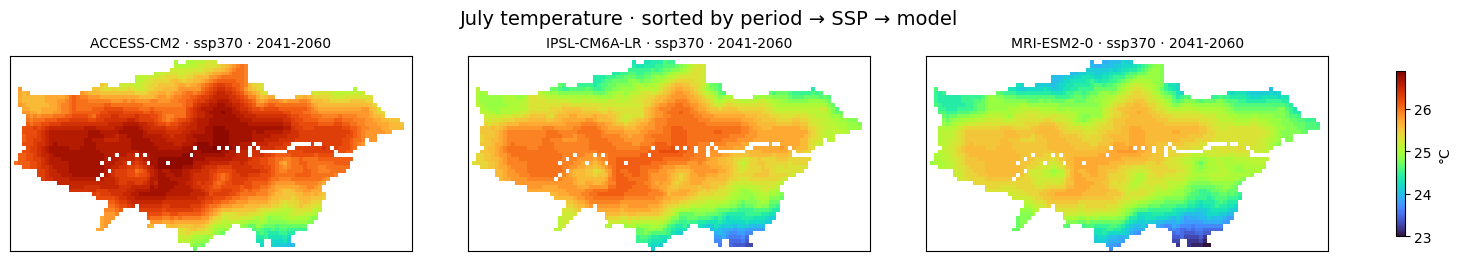

In [47]:
# keep only ssp370
ssp370_files = [p for p in tifs if "ssp370" in p.name and "2041-2060" in p.name]
print(ssp370_files)


plot_july_sorted_by_ssp_year_model(
    ssp370_files,
    ncols=3,
    cmap="turbo",           # or "plasma"
    vmin=None, vmax=None,
    title="July temperature · sorted by period → SSP → model",
    save_png=dir_gcm/ "figures" / "july_all_models_sorted_ssp370.png",
)

## Plot - chesla

### reload clipped tifs

In [ ]:
dir_clipped_chelsa = out_chelsa

# tifs = sorted([p for p in dir_clipped.rglob("*.tif")])
## use the earlier defined function to list tifs at top level
tifs = list_tifs(dir_clipped_chelsa)


# keep only july from 2015 onwards
tifs_chesla_july = [p for p in tifs 
                    if "_07" in p.name and int(p.stem.split("_")[3]) >= 2015
                    ]

# print each tif
for t in tifs_chesla_july:
    print(t)

E:\chelsa02\clipped_london\CHELSA_tasmax_07_2015_V.2.1_London.tif
E:\chelsa02\clipped_london\CHELSA_tasmax_07_2016_V.2.1_London.tif
E:\chelsa02\clipped_london\CHELSA_tasmax_07_2017_V.2.1_London.tif
E:\chelsa02\clipped_london\CHELSA_tasmax_07_2018_V.2.1_London.tif
E:\chelsa02\clipped_london\CHELSA_tasmax_07_2019_V.2.1_London.tif
E:\chelsa02\clipped_london\CHELSA_tasmax_07_2020_V.2.1_London.tif
E:\chelsa02\clipped_london\CHELSA_tasmax_07_2021_V.2.1_London.tif


### plot

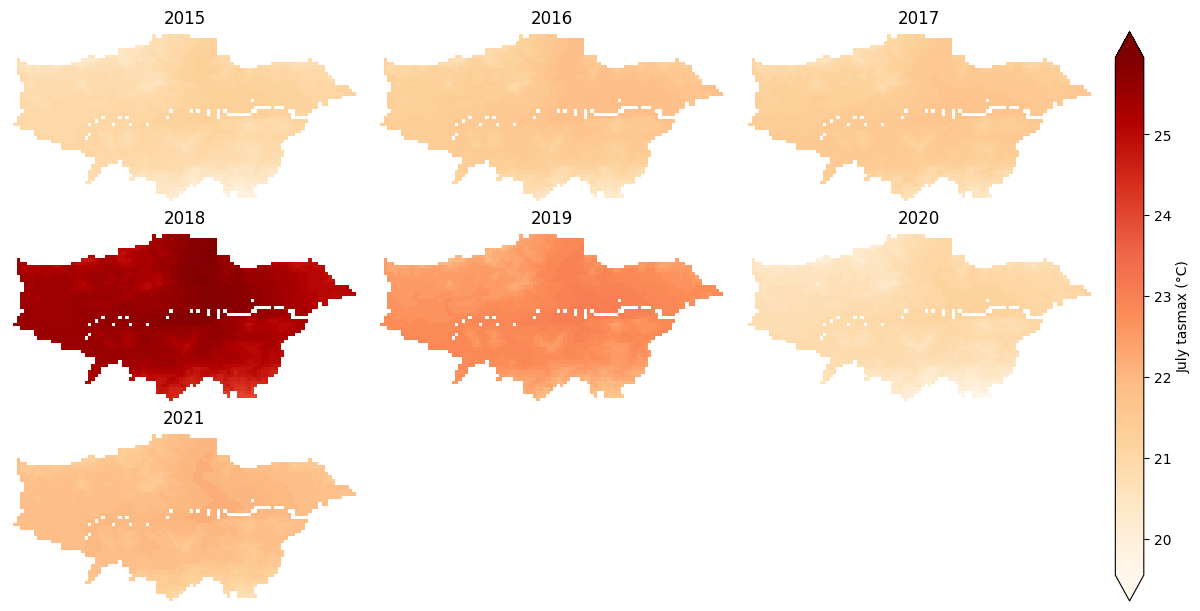

In [ ]:
rasters_c = []
years = []

for p in tifs_chesla_july:
    # 1) read and convert K → °C
    with rasterio.open(p) as src:
        arr = src.read(1).astype(float)
        if src.nodata is not None:
            arr = np.where(arr == src.nodata, np.nan, arr)
        # CHELSA V2.1 temp decode:
        arr_c = arr * 0.1 - 273.15
        rasters_c.append(arr_c)

    # 2) robust year parse
    m = re.search(r"_07_(\d{4})_", p.name)
    if m:
        year = m.group(1)
    else:
        # fallback: grab the first 4-digit number in name
        m2 = re.search(r"(\d{4})", p.stem)
        year = m2.group(1) if m2 else "NA"
    years.append(year)

# common scale
all_vals = np.concatenate([r.flatten() for r in rasters_c])
all_vals = all_vals[~np.isnan(all_vals)]
vmin, vmax = float(all_vals.min()), float(all_vals.max())

n = len(rasters_c)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 2*nrows), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

for ax, arr_c, yr in zip(axes, rasters_c, years):
    im = ax.imshow(arr_c, vmin=vmin, vmax=vmax, cmap="OrRd")
    ax.set_title(yr)
    ax.set_axis_off()

# turn off leftover axes
for ax in axes[len(rasters_c):]:
    ax.set_axis_off()

cbar = plt.colorbar(im, ax=axes.tolist(), extend='both', fraction=0.03, pad=0.02)
cbar.set_label("July tasmax (°C)")

plt.show()

# Stats

### change by Borough

In [ ]:
# from rasterstats import zonal_stats

# # --- Step 5: Violin Plot by Administrative Region ---
# # Compute zonal statistics (mean temperature change per region)
# zonal_stats_result = zonal_stats(
#     aoi_adm, 
#     str(temp_change_output_path),   # (ok to pass Path, but string is safest)
#     nodata=-9999.0,  # whatever you wrote as nodata
#     geojson_out=True,
#     stats=["mean"])


# # Convert to GeoDataFrame to keep properties + geometry
# import geopandas as gpd
# zs_gdf = gpd.GeoDataFrame.from_features(zonal_stats_result)
# # print(zs_gdf.head())


# # Convert zonal stats to DataFrame
# df_zonal = pd.DataFrame(zs_gdf)

# # Rename 'mean' → 'temp_change_mean'
# df_zonal = df_zonal.rename(columns={"mean": "temp_change_mean"}) 

# # Drop unwanted columns
# cols_to_drop = ["HECTARES", "NONLD_AREA", "ONS_INNER", "SUB_2009", "SUB_2006", "geometry"]
# df_zonal = df_zonal.drop(columns=cols_to_drop, errors="ignore")  # <<< errors="ignore" skips if not present



# # save the zonal stats to CSV
# zonal_stats_csv_path = dir_ucm_out / "ucm_output_postprocess" / f"zonal_stats_temp_change_{suffix_change}.csv"
# df_zonal.to_csv(zonal_stats_csv_path, index=False)
# print(f"[OK] Zonal stats saved → {zonal_stats_csv_path}")

#### function - aggregate_tmax_by_borough

In [ ]:
from pathlib import Path
import numpy as np
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import pandas as pd
import matplotlib.pyplot as plt

def _p05(arr):
    a = np.ma.compressed(arr)   # drop masked
    return float(np.percentile(a, 5)) if a.size else np.nan

def _p95(arr):
    a = np.ma.compressed(arr)
    return float(np.percentile(a, 95)) if a.size else np.nan

def aggregate_tmax_by_borough(
    raster_path,
    boroughs_path,
    band=7,                 # July in WorldClim 12-band
    id_col="NAME",          # borough name field
    out_csv=None,
    scale: float | None = None,
    offset: float | None = None,
):
    """
    Zonal-stats over London boroughs for a given raster band.

    scale/offset are applied to the raster BEFORE stats:
      value = raw * scale + offset
    For CHELSA V2.1 tasmax: scale=0.1, offset=-273.15

    - reprojects boroughs to the raster CRS
    - runs rasterstats.zonal_stats with stats we want
    - returns a tidy DataFrame: borough, mean, median, p05, p95, count
    """
    raster_path = Path(raster_path)
    boroughs_path = Path(boroughs_path)

    # 1) open raster once → get CRS
    with rasterio.open(raster_path) as src:
        r_crs = src.crs
        nodata = src.nodata

    # 2) read boroughs and reproject to raster CRS
    gdf = gpd.read_file(boroughs_path)
    if gdf.crs is None:
        raise ValueError("Borough shapefile has no CRS.")
    if r_crs and gdf.crs != r_crs:
        gdf = gdf.to_crs(r_crs)

    # wrapper to apply scale/offset to the array that zonal_stats passes in
    def _apply_scale(arr):
        a = np.ma.array(arr, copy=True)
        if scale is not None:
            a = a * scale
        if offset is not None:
            a = a + offset
        return a

    # 3) run zonal_stats
    # zs = zonal_stats(
    #     gdf,
    #     raster_path,
    #     stats=["mean", "median", "count"],
    #     add_stats={"p05": _p05, "p95": _p95},
    #     band=band,
    #     nodata=None,      # use raster's nodata
    #     geojson_out=False,
    # )

    zs = zonal_stats(
        gdf,
        raster_path,
        stats=["count"],          # we'll handle mean/median ourselves to include scaling
        band=band,
        nodata=nodata,
        add_stats={
            "p05": lambda x: _p05(_apply_scale(x)),
            "p95": lambda x: _p95(_apply_scale(x)),
            "mean_s": lambda x: float(np.mean(np.ma.compressed(_apply_scale(x)))) if np.ma.compressed(_apply_scale(x)).size else np.nan,
            "median_s": lambda x: float(np.median(np.ma.compressed(_apply_scale(x)))) if np.ma.compressed(_apply_scale(x)).size else np.nan,
        },
        geojson_out=False,
    )

    # 4) build DF
    rows = []
    for feat, st in zip(gdf.itertuples(), zs):
        rows.append({
            "borough": getattr(feat, id_col),
            "mean": st.get("mean_s"),
            "median": st.get("median_s"),
            "p05": st.get("p05"),
            "p95": st.get("p95"),
            "count": st.get("count"),
        })
    df = pd.DataFrame(rows).sort_values("borough").reset_index(drop=True)

    # 5) save
    if out_csv:
        out_csv = Path(out_csv)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_csv, index=False)
        print("saved →", out_csv)

    return df



#### function - plot_borough_stats

In [48]:

import matplotlib as mpl
import function_make_map_scale  # your file

def plot_borough_stats(
    boroughs_path: str | Path,
    stats_df: pd.DataFrame,
    id_col: str = "NAME",
    value_col: str = "mean",
    title: str = "July Tmax (°C) by borough",
    save_png: str | Path | None = None,
):
    """
    Join stats back to borough polygons and plot a choropleth.
    """
    gdf = gpd.read_file(boroughs_path)
    gdf = gdf.merge(stats_df, left_on=id_col, right_on="borough", how="left")

    vals = gdf[value_col].to_numpy()


    # get scale, cmap, norm, extend
    vmin, vmax, cmap, norm, extend_mode = function_make_map_scale.make_map_scale(vals)

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    colors = [sm.to_rgba(v) if v is not None else (0.9, 0.9, 0.9, 1) for v in vals]


    fig, ax = plt.subplots(figsize=(7, 5))

    # plot without legend so we can control colorbar
    gdf.plot(
        color=colors,
        edgecolor="black",
        linewidth=0.3,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_axis_off()
    if title:
        ax.set_title(title)

    # make colorbar
    # proper colorbar
    sm._A = []  # needed for older mpl
    cbar = plt.colorbar(sm, ax=ax, extend=extend_mode, fraction=0.03, pad=0.04)
    # `fraction` - Make the colorbar thinner than the default; `pad` - space between plot and colorbar
    cbar.ax.set_yscale('linear')
    cbar.set_label("Temperature (°C)")

    # save figure
    if save_png is not None:
        save_png = Path(save_png)
        save_png.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_png, dpi=200, bbox_inches="tight")
        print("Saved figure:", save_png)

    plt.show()


Analyzing raster: E:\GCMs\clipped\wc2.1_30s_tmax_ACCESS-CM2_ssp370_2041-2060_London.tif
saved → E:\GCMs\clipped\stats\london_tmax_july_by_borough.csv
Saved figure: E:\GCMs\figures\london_tmax_july_by_borough_mean.png


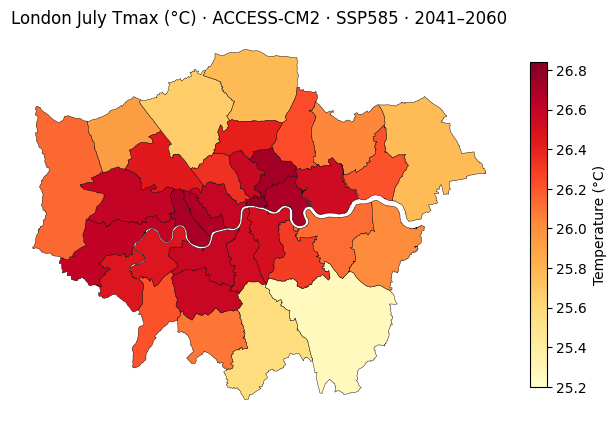

In [50]:
raster = ssp370_files[0]  # pick one raster to analyze
print("Analyzing raster:", raster)

boroughs = admin_shapefile

df_boro = aggregate_tmax_by_borough(
    raster_path=raster,
    boroughs_path=boroughs,
    band=7,  # July
    id_col="NAME",
    out_csv=dir_clipped / "stats" / "london_tmax_july_by_borough.csv",
)

plot_borough_stats(
    boroughs_path=boroughs,
    stats_df=df_boro,
    id_col="NAME",
    value_col="mean",
    title="London July Tmax (°C) · ACCESS-CM2 · SSP585 · 2041–2060",
    save_png=dir_gcm / "figures" / "london_tmax_july_by_borough_mean.png",
)


#### batch - worldclim

[WindowsPath('E:/GCMs/clipped/wc2.1_30s_tmax_ACCESS-CM2_ssp370_2061-2080_London.tif'), WindowsPath('E:/GCMs/clipped/wc2.1_30s_tmax_IPSL-CM6A-LR_ssp370_2061-2080_London.tif'), WindowsPath('E:/GCMs/clipped/wc2.1_30s_tmax_MRI-ESM2-0_ssp370_2061-2080_London.tif')]
saved → E:\GCMs\clipped\stats\borough_stats_wc2.1_30s_tmax_ACCESS-CM2_ssp370_2061-2080_London.csv
saved → E:\GCMs\clipped\stats\borough_stats_wc2.1_30s_tmax_IPSL-CM6A-LR_ssp370_2061-2080_London.csv
saved → E:\GCMs\clipped\stats\borough_stats_wc2.1_30s_tmax_MRI-ESM2-0_ssp370_2061-2080_London.csv
Saved figure: E:\GCMs\figures\borough_map_wc2.1_30s_tmax_ACCESS-CM2_ssp370_2061-2080_London.png


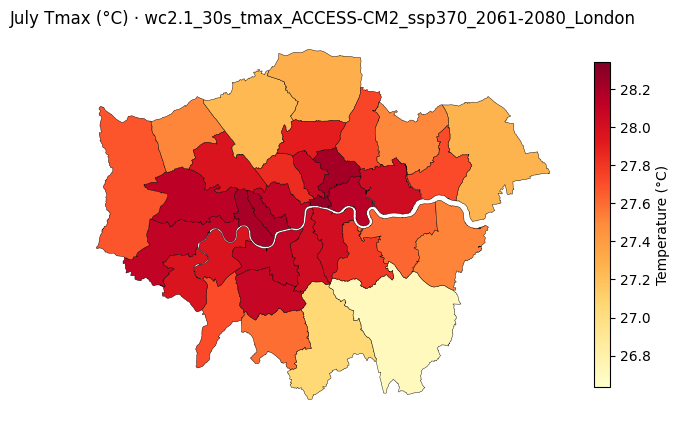

Saved figure: E:\GCMs\figures\borough_map_wc2.1_30s_tmax_IPSL-CM6A-LR_ssp370_2061-2080_London.png


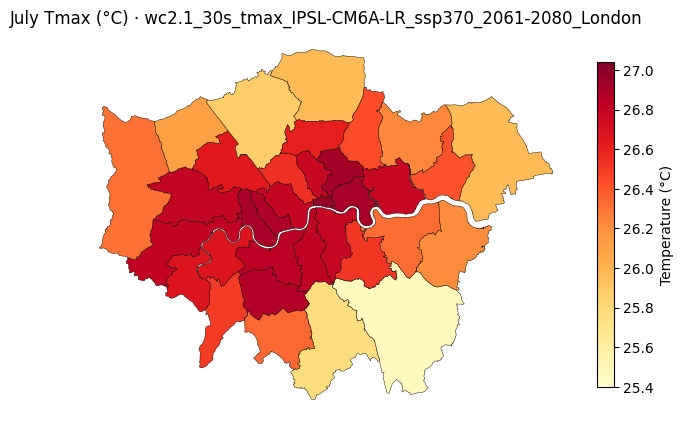

Saved figure: E:\GCMs\figures\borough_map_wc2.1_30s_tmax_MRI-ESM2-0_ssp370_2061-2080_London.png


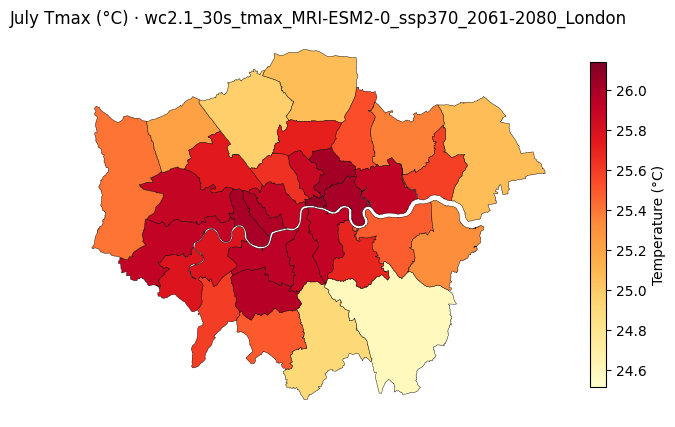

In [54]:

# subset to ssp_i and year_i
ssp_i = 'ssp370';
# year_i = '2041-2060';
year_i = '2061-2080';

ssp_subset = [p for p in tifs if ssp_i in p.name and year_i in p.name]
print(ssp_subset)


# 1) run zonal stats once per raster + store
all_stats = {}
all_vals = []

for rpath in ssp_subset:
    df_boro = aggregate_tmax_by_borough(
        raster_path=rpath,
        boroughs_path=boroughs,
        band=7,
        id_col="NAME",
        out_csv=dir_gcm / "clipped" / "stats" / f"borough_stats_{rpath.stem}.csv",
    )
    all_stats[rpath] = df_boro
    all_vals.append(df_boro["mean"].values)

# 2) compute global scale
import numpy as np
all_vals = np.concatenate(all_vals)
vmin = float(np.nanmin(all_vals))
vmax = float(np.nanmax(all_vals))
ticks = list(np.linspace(vmin, vmax, 7))  # 7 ticks

# 3) plot all with the SAME vmin/vmax/ticks
for rpath, df_boro in all_stats.items():
    plot_borough_stats(
        boroughs_path=boroughs,
        stats_df=df_boro,
        id_col="NAME",
        value_col="mean",
        title=f"July Tmax (°C) · {rpath.stem}",
        save_png=dir_gcm / "figures" / f"borough_map_{rpath.stem}.png",
    )

#### batch - chesla

saved → E:\chelsa02\clipped_london_stats\borough_stats_CHELSA_tasmax_07_2015_V.2.1_London.csv
saved → E:\chelsa02\clipped_london_stats\borough_stats_CHELSA_tasmax_07_2016_V.2.1_London.csv
saved → E:\chelsa02\clipped_london_stats\borough_stats_CHELSA_tasmax_07_2017_V.2.1_London.csv
saved → E:\chelsa02\clipped_london_stats\borough_stats_CHELSA_tasmax_07_2018_V.2.1_London.csv
saved → E:\chelsa02\clipped_london_stats\borough_stats_CHELSA_tasmax_07_2019_V.2.1_London.csv
saved → E:\chelsa02\clipped_london_stats\borough_stats_CHELSA_tasmax_07_2020_V.2.1_London.csv
saved → E:\chelsa02\clipped_london_stats\borough_stats_CHELSA_tasmax_07_2021_V.2.1_London.csv
Saved figure: E:\chelsa02\figures\borough_map_CHELSA_tasmax_07_2015_V.2.1_London.png


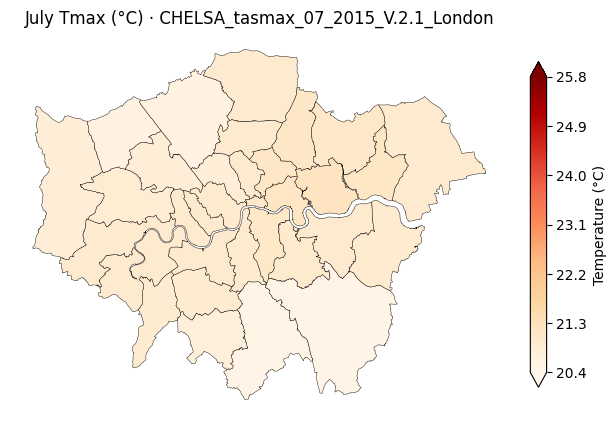

Saved figure: E:\chelsa02\figures\borough_map_CHELSA_tasmax_07_2016_V.2.1_London.png


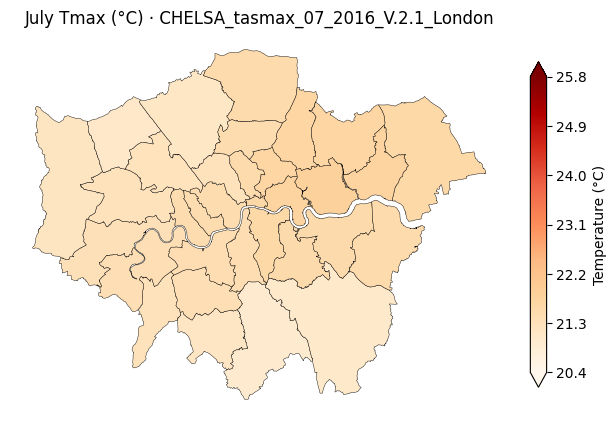

Saved figure: E:\chelsa02\figures\borough_map_CHELSA_tasmax_07_2017_V.2.1_London.png


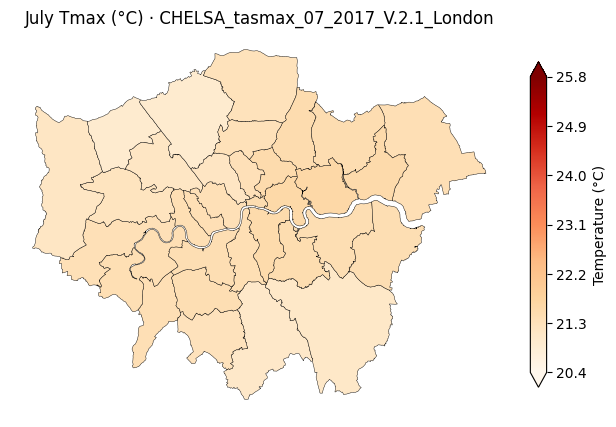

Saved figure: E:\chelsa02\figures\borough_map_CHELSA_tasmax_07_2018_V.2.1_London.png


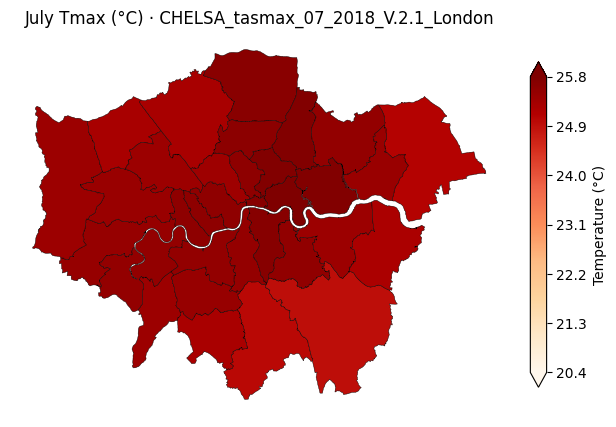

Saved figure: E:\chelsa02\figures\borough_map_CHELSA_tasmax_07_2019_V.2.1_London.png


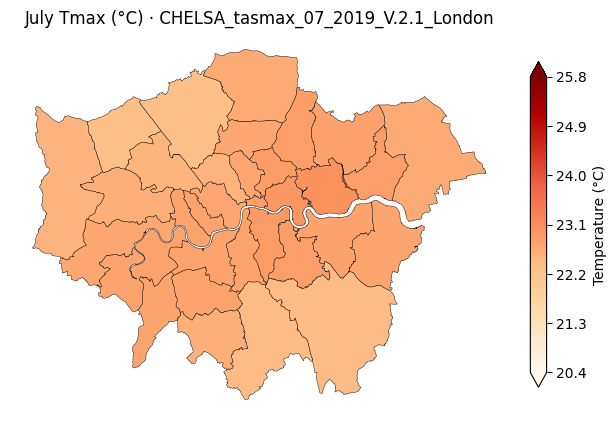

Saved figure: E:\chelsa02\figures\borough_map_CHELSA_tasmax_07_2020_V.2.1_London.png


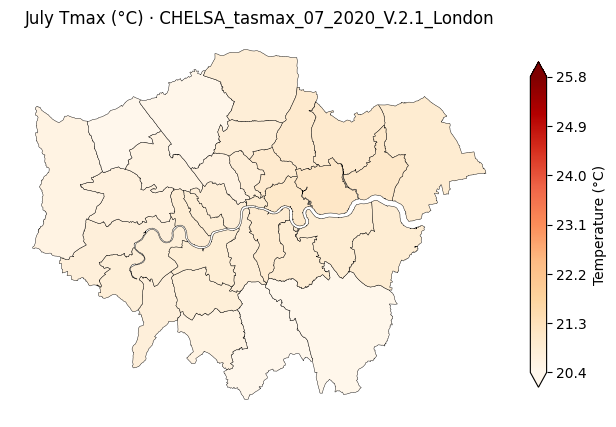

Saved figure: E:\chelsa02\figures\borough_map_CHELSA_tasmax_07_2021_V.2.1_London.png


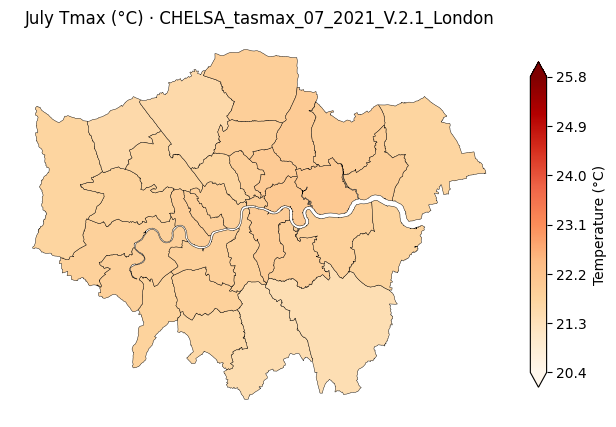

In [ ]:
# 1) run zonal stats once per raster + store
all_stats = {}
all_vals = []

for rpath in tifs_chesla_july:
    df_boro = aggregate_tmax_by_borough(
        raster_path=rpath,
        boroughs_path=boroughs,
        band=1,
        id_col="NAME",
        out_csv=Path("E:/chelsa02") / 'clipped_london_stats' /  f"borough_stats_{rpath.stem}.csv",
        scale=0.1,
        offset=-273.15,
    )
    all_stats[rpath] = df_boro
    all_vals.append(df_boro["mean"].values)

# 2) compute global scale
import numpy as np
all_vals = np.concatenate(all_vals)
vmin = float(np.nanmin(all_vals))
vmax = float(np.nanmax(all_vals))
ticks = list(np.linspace(vmin, vmax, 7))  # 7 ticks

# 3) plot all with the SAME vmin/vmax/ticks
for rpath, df_boro in all_stats.items():
    plot_borough_stats(
        boroughs_path=boroughs,
        stats_df=df_boro,
        id_col="NAME",
        value_col="mean",
        title=f"July Tmax (°C) · {rpath.stem}",
        cmap="OrRd",
        vmin=vmin,
        vmax=vmax,
        ticks=ticks,
        save_png=Path("E:/chelsa02") / "figures" / f"borough_map_{rpath.stem}.png",
    )

### change over time 

In [ ]:
import pandas as pd

# load
df1 = pd.read_csv(r"E:\chelsa02\clipped_london_stats\borough_stats_CHELSA_tasmax_07_2021_V.2.1_London.csv")
df2 = pd.read_csv(r"E:\GCMs\clipped\stats\borough_stats_wc2.1_30s_tmax_ACCESS-CM2_ssp370_2041-2060_London.csv"); model_name = "ACCESS-CM2"
df2 = pd.read_csv(r"E:\GCMs\clipped\stats\borough_stats_wc2.1_30s_tmax_IPSL-CM6A-LR_ssp370_2041-2060_London.csv"); model_name = "IPSL-CM6A-LR"

# join by borough (inner)
df_join = df1.merge(df2, on="borough", how="inner", suffixes=("_b", "_s"))

df_join["mean_diff"] = df_join["mean_s"] - df_join["mean_b"]

print(df_join.head())


# # 4) join to spatial
# gdf = aoi_adm.merge(df_join, left_on="NAME", right_on="borough", how="left")

# vmin, vmax, cmap, norm, extend = function_make_map_scale.make_map_scale(gdf["mean_diff"].to_numpy())

# # 5) plot
# ax = gdf.plot(
#     column="mean_diff",
#     # cmap="RdBu_r",
#     cmap=cmap,
#     norm=norm,
#     legend=True,
#     edgecolor="black",
#     linewidth=0.3,
#     figsize=(7, 3.5),
#     missing_kwds={"color": "lightgrey", "label": "No data"},
# )
# ax.set_title("July tasmax: 2021 – 2050 (°C)")
# ax.set_axis_off()

                borough     mean_b  median_b  p05_b  p95_b  count_b  \
0  Barking and Dagenham  21.963636     21.95  21.85  22.05       66   
1                Barnet  21.612112     21.65  21.35  21.75      161   
2                Bexley  21.794643     21.75  21.65  21.95      112   
3                 Brent  21.756098     21.75  21.65  21.85       82   
4               Bromley  21.462635     21.55  20.85  21.85      277   

      mean_s   median_s      p05_s      p95_s  count_s  mean_diff  
0  25.617643  25.700001  25.235001  25.799999       68   3.654007  
1  24.974533  25.000000  24.500000  25.500000      161   3.362421  
2  25.400883  25.400000  25.200001  25.700001      113   3.606240  
3  25.734142  25.700001  25.400000  26.000000       82   3.978045  
4  24.644203  24.700001  23.600000  25.600000      276   3.181568  


Saved figure: d:\natcap\urban-cooling-health\figures\T_change_borough_map_IPSL-CM6A-LR.png


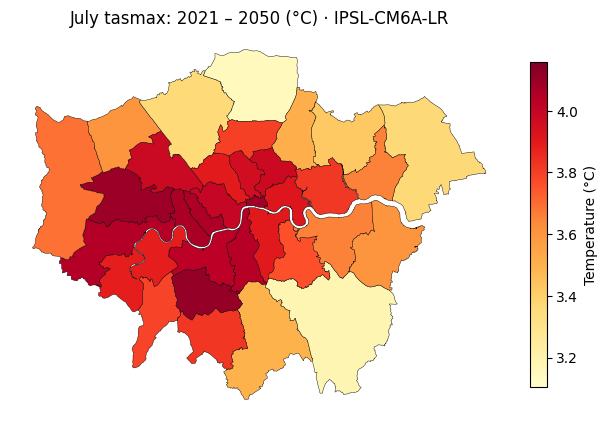

In [ ]:
plot_borough_stats(
        boroughs_path=admin_shapefile,
        stats_df=df_join,
        id_col="NAME",
        value_col="mean_diff",
        title=f"July tasmax: 2021 – 2050 (°C) · {model_name}",
        save_png= dir_fig / f"T_change_borough_map_{model_name}.png",
    )

### stats

In [ ]:
from pathlib import Path
import re
import math
import numpy as np
import pandas as pd
import rasterio

# ---------- filename parser (tolerant to suffixes like _London) ----------


# ---------- helpers ----------
MONTHS_12 = ("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")

def _coslat_weights(src):
    """
    Return a 2D weight array proportional to cos(latitude) for EPSG:4326 rasters.
    For London-scale AOIs, effect is small; set weight=None to disable.
    """
    # lat per row from bounds; assumes north-up, regular grid
    top, bottom = src.bounds.top, src.bounds.bottom
    nrows = src.height
    lats = np.linspace(top, bottom, nrows, endpoint=False)  # row-centered approx
    w = np.cos(np.deg2rad(lats))
    w[w < 0] = 0  # guard (shouldn't happen here)
    return np.repeat(w[:, None], src.width, axis=1).astype("float32")

def _nanstats(arr, w=None):
    """
    Compute summary stats on a 2D array with NaNs. Optional weights (same shape).
    Returns dict.
    """
    a = arr.astype("float64")
    mask = ~np.isnan(a)
    n_valid = int(mask.sum())
    n_total = a.size
    n_nodata = n_total - n_valid
    if n_valid == 0:
        return dict(mean=np.nan, median=np.nan, std=np.nan, vmin=np.nan, p10=np.nan, p90=np.nan, vmax=np.nan,
                    count=n_valid, nodata_count=n_nodata)

    if w is not None:
        w = w.astype("float64")
        w = np.where(mask, w, np.nan)
        # normalized weights over valid cells
        wsum = np.nansum(w)
        if wsum == 0 or np.isnan(wsum):
            w = None  # fallback
        else:
            wn = w / wsum
    else:
        wn = None

    vals = a[mask]
    if wn is None:
        avg = float(np.nanmean(vals))
        med = float(np.nanmedian(vals))
        sd  = float(np.nanstd(vals, ddof=0))
    else:
        wvals = wn[mask]
        avg = float(np.nansum(vals * wvals))
        # weighted median (approx via quantile)
        # build CDF over sorted values
        order = np.argsort(vals)
        v_sorted = vals[order]
        w_sorted = wvals[order]
        cdf = np.cumsum(w_sorted)
        med = float(v_sorted[np.searchsorted(cdf, 0.5)])
        # weighted std (population) around weighted mean
        sd = float(np.sqrt(np.nansum(wvals * (vals - avg)**2)))

    p5 = float(np.nanpercentile(vals, 5))
    p10 = float(np.nanpercentile(vals, 10))
    p90 = float(np.nanpercentile(vals, 90))
    p95 = float(np.nanpercentile(vals, 95))
    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals))

    return dict(mean=avg, median=med, std=sd, vmin=vmin, p5=p5, p10=p10, p90=p90, p95=p95, vmax=vmax,
                count=n_valid, nodata_count=n_nodata)

# ---------- main: batch summary to Excel ----------
def summarize_rasters_to_excel(
    tif_paths: list[Path] | list[str],
    out_xlsx: Path | str,
    band_subset: list[int] | None = None,   # e.g., [7] for July; default = all bands
    weight: str | None = None,              # None or "coslat"
    engine: str = "xlsxwriter",             # or "openpyxl"
) -> Path:
    """
    Compute per-band summary stats for each raster and save to an Excel file.

    Output columns:
      file, var, model, ssp, period, band, month, mean, median, std, vmin, p10, p90, vmax, count, nodata_count
    """
    records = []
    tif_paths = [Path(p) for p in tif_paths]

    for tif in tif_paths:
        parts = parse_worldclim_parts(tif)
        with rasterio.open(tif) as src:
            # choose bands
            bands = band_subset if band_subset else list(range(1, src.count + 1))
            # weights (optional): only meaningful for lon/lat grids (EPSG:4326)
            W = _coslat_weights(src) if (weight == "coslat" and src.crs and src.crs.to_epsg() == 4326) else None

            for b in bands:
                arr = src.read(b).astype("float32")
                if src.nodata is not None:
                    arr = np.where(arr == src.nodata, np.nan, arr)

                stats = _nanstats(arr, w=W)

                month = MONTHS_12[b-1] if src.count == 12 and 1 <= b <= 12 else None
                rec = {
                    "file": tif.name,
                    "var": parts["var"],
                    "model": parts["model"],
                    "ssp": parts["ssp"],
                    "period": parts["period"],
                    "band": b,
                    "month": month,
                    **stats
                }
                records.append(rec)

    df = pd.DataFrame.from_records(records)
    out_xlsx = Path(out_xlsx)
    out_xlsx.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(out_xlsx, engine=engine) as xw:
        df.to_excel(xw, sheet_name="summary", index=False)
    print(f"Saved summary → {out_xlsx}")
    return out_xlsx




# 1) Collect your clipped rasters (non-recursive or recursive as you prefer)
## use listed rasters above ``tifs``

# 2) Summarize ALL bands (Jan–Dec) for each file (unweighted)
summarize_rasters_to_excel(
    tif_paths=tifs,
    out_xlsx=dir_clipped / "stats" / "worldclim_tmax_summary.xlsx",
    band_subset=None,      # all
    weight=None            # or "coslat"
)

# 3) Summarize only July (band 7), with cos(lat) weights (EPSG:4326 only)
summarize_rasters_to_excel(
    tif_paths=tifs,
    out_xlsx=dir_clipped / "stats" / "worldclim_tmax_July_weighted.xlsx",
    band_subset=[7],
    weight="coslat"
)


Saved summary → E:\GCMs\clipped\stats\worldclim_tmax_summary.xlsx
Saved summary → E:\GCMs\clipped\stats\worldclim_tmax_July_weighted.xlsx


WindowsPath('E:/GCMs/clipped/stats/worldclim_tmax_July_weighted.xlsx')

## IPCC figure

In [ ]:
from pathlib import Path
import re, math, random
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

# -----------------------
# 1) Filename parser
# -----------------------


# -----------------------
# 2) Read July (band 7) mean
# -----------------------
def _coslat_weights(src):
    # simple cos(lat) weights for EPSG:4326 grids
    top, bottom = src.bounds.top, src.bounds.bottom
    nrows = src.height
    lats = np.linspace(top, bottom, nrows, endpoint=False)
    w = np.cos(np.deg2rad(lats))
    w = np.clip(w, 0, None)
    return np.repeat(w[:, None], src.width, axis=1).astype("float64")

def july_mean_from_tif(tif_path: Path, weight: bool = True) -> float:
    with rasterio.open(tif_path) as src:
        if src.count < 7:
            raise ValueError(f"{tif_path.name} has only {src.count} band(s); need ≥ 7 for July.")
        arr = src.read(7).astype("float64")
        if src.nodata is not None:
            arr = np.where(arr == src.nodata, np.nan, arr)
        mask = ~np.isnan(arr)
        if not mask.any():
            return np.nan
        if weight and src.crs and src.crs.to_epsg() == 4326:
            W = _coslat_weights(src)
            W = np.where(mask, W, np.nan)
            wsum = np.nansum(W)
            if wsum > 0:
                return float(np.nansum(arr * (W / wsum)))
        # unweighted fallback
        return float(np.nanmean(arr))


# Load July means from the Excel summary -----------------
import pandas as pd

def load_july_means_from_excel(
    xlsx_path,
    var="tmax",                           # "tmax"/"tmin"/"tas"/"tx"/"tn" as saved in Excel
    stats_col="mean",                     # which stat to use for plotting (e.g., "mean" or "median")
):
    """
    Reads the Excel produced by summarize_rasters_to_excel(...),
    filters to July (band 7 / month == 'Jul'), and returns a tidy df with:
    ['model','ssp_canon','period','period_start','july_tmax_c'].
    """
    df = pd.read_excel(xlsx_path, sheet_name="summary")

    # Robust month filter (works whether month is 'Jul' or band==7)
    if "month" in df.columns and df["month"].notna().any():
        july_mask = df["month"].str.lower().eq("jul")
    else:
        july_mask = df["band"].eq(7)

    sub = df.loc[july_mask].copy()

    # Keep only the variable you want (e.g., tmax)
    if "var" in sub.columns and pd.notna(var):
        sub = sub[sub["var"].str.lower() == var.lower()]

    # Canonicalize SSP (remove hyphens: 'ssp3-7.0' -> 'ssp370')
    sub["ssp_canon"] = sub["ssp"].str.lower().str.replace("-", "", regex=False)

    # Period start for ordering on x-axis
    sub["period_start"] = sub["period"].str.split("-").str[0].astype(int)

    # Choose the statistic from the summary (default: mean)
    if stats_col not in sub.columns:
        raise ValueError(f"Column '{stats_col}' not found in Excel; available: {list(sub.columns)}")

    sub = sub.rename(columns={stats_col: "july_tmax_c"})

    # Keep the columns the plotting function expects
    cols = ["model", "ssp", "ssp_canon", "period", "period_start", "july_tmax_c", "file"]
    return sub[[c for c in cols if c in sub.columns]].reset_index(drop=True)




# -----------------------
# 4) IPCC-style panel plot
# -----------------------
import math, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_ipcc_style_july(
    df: pd.DataFrame,
    ssp_order=("ssp126","ssp245","ssp370","ssp585"),
    period_order=("2021-2040","2041-2060","2061-2080","2081-2100"),
    title="London · July mean Tmax (°C) · WorldClim CMIP6",
    save_png: Path | None = None,
    model_colors: dict | None = None,
    mean_label_fmt="{:.1f}",          # <-- format for mean labels
    mean_marker_kwargs=None,          # e.g., dict(marker="s", color="black", markersize=5)
    mean_text_kwargs=None,            # e.g., dict(color="black", fontsize=9)
):
    """
    Expects df from load_july_means_from_excel(...):
      columns: ['model','ssp','ssp_canon','period','july_tmax_c', ...]
    Adds: legend at bottom; labels the per-period MEAN (across models) with text.
    """
    # filter
    df = df[df["ssp_canon"].isin(ssp_order) & df["period"].isin(period_order)].copy()
    if df.empty:
        raise ValueError("No rows after filtering by SSP and period. Check inputs.")

    # y-scale
    y_min = math.floor(df["july_tmax_c"].min() - 0.5) if df["july_tmax_c"].notna().any() else 0
    y_max = math.ceil(df["july_tmax_c"].max() + 0.5) if df["july_tmax_c"].notna().any() else 1

    # colors per model
    models_all = sorted(df["model"].dropna().unique())
    if model_colors is None:
        cmap = plt.get_cmap("tab20")
        model_colors = {m: cmap(i % 20) for i, m in enumerate(models_all)}
    else:
        cmap = plt.get_cmap("tab20")
        for i, m in enumerate(models_all):
            model_colors.setdefault(m, cmap(i % 20))

    # defaults for mean marker/text
    if mean_marker_kwargs is None:
        mean_marker_kwargs = dict(marker="s", color="black", markersize=5, zorder=3)
    if mean_text_kwargs is None:
        mean_text_kwargs = dict(color="black", fontsize=9, ha="center", va="bottom")

    ncols = len(ssp_order)
    fig, axes = plt.subplots(1, ncols, figsize=(4.8*ncols, 5.6), sharey=True, constrained_layout=False)
    if ncols == 1:
        axes = [axes]

    # for bottom legend
    legend_handles, legend_labels = [], []

    for ax, ssp in zip(axes, ssp_order):
        sub = df[df["ssp_canon"] == ssp]
        ax.set_title(ssp.upper(), fontweight="bold")

        xpos = np.arange(len(period_order))
        # box data per period
        data_for_boxes = [sub.loc[sub["period"] == per, "july_tmax_c"].dropna().values for per in period_order]
        ax.boxplot(
            data_for_boxes, positions=xpos, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor="#dddddd", edgecolor="black"),
            medianprops=dict(color="black", linewidth=1.5),
            whiskerprops=dict(color="black"), capprops=dict(color="black")
        )

        # overlay model-colored dots + lines
        models = sorted(sub["model"].dropna().unique())
        for m in models:
            c = model_colors.get(m, "#333333")
            vals, xs = [], []
            for i, per in enumerate(period_order):
                v = sub.loc[(sub["model"] == m) & (sub["period"] == per), "july_tmax_c"]
                if not v.empty and np.isfinite(v.iloc[0]):
                    xs.append(i + (random.random() - 0.5) * 0.12)
                    vals.append(v.iloc[0])
            if xs:
                ln, = ax.plot(xs, vals, marker="o", linewidth=0.9, markersize=4,
                              alpha=0.95, color=c, label=m)
                if m not in legend_labels:
                    legend_handles.append(ln)
                    legend_labels.append(m)

        # compute and annotate MEAN per period
        for i, per in enumerate(period_order):
            v = sub.loc[sub["period"] == per, "july_tmax_c"].dropna().values
            if v.size:
                mean_val = float(np.mean(v))
                # draw a small square at the mean
                ax.plot([i], [mean_val], **mean_marker_kwargs)
                # place text slightly above the marker
                ax.text(i, mean_val, mean_label_fmt.format(mean_val), **mean_text_kwargs)

        ax.set_xticks(xpos)
        ax.set_xticklabels(period_order, rotation=0)
        ax.set_ylim(y_min, y_max)
        ax.grid(True, axis="y", linestyle=":", alpha=0.5)
        ax.set_xlabel("Period")

    axes[0].set_ylabel("July mean Tmax (°C)")
    fig.suptitle(title, fontsize=13)

    # --- legend at the bottom ---
    # make some room at the bottom for legend
    plt.subplots_adjust(bottom=0.2, top=0.88, wspace=0.15)
    fig.legend(
        legend_handles, legend_labels,
        loc="lower center", ncol=min(5, len(legend_labels)), frameon=False,
        bbox_to_anchor=(0.5, 0.02)
    )

    if save_png:
        save_png = Path(save_png)
        save_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_png, dpi=200, bbox_inches="tight")
        print("Saved figure:", save_png)

    plt.show()



### run 

Saved figure: E:\GCMs\figures\july_tmax_ipcc_models_labels_mean.png


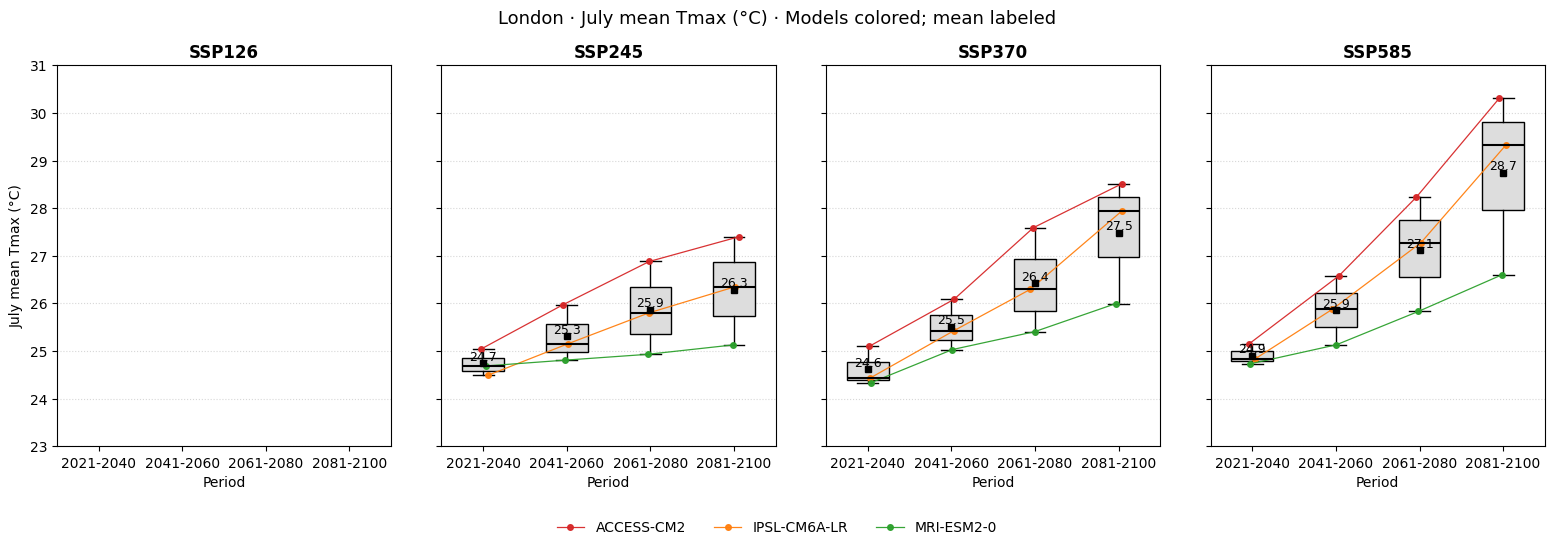

In [ ]:

# -----------------------
# 5) Run it
# -----------------------


# 1) Load the July means you already summarized:
df_july = load_july_means_from_excel(
    xlsx_path=dir_gcm / "clipped" / "stats" / "worldclim_tmax_summary.xlsx",
    var="tmax", stats_col="mean"   # or "median"
)

# 2) (Optional) set custom colors for specific models
my_colors = {
    "EC-Earth3-Veg": "#1f77b4",
    "IPSL-CM6A-LR":  "#ff7f0e",
    "MRI-ESM2-0":    "#2ca02c",
    "ACCESS-CM2":    "#d62728",
    "MIROC6":        "#9467bd",
}


plot_ipcc_style_july(
    df_july,
    ssp_order=("ssp126","ssp245","ssp370","ssp585"),
    period_order=("2021-2040","2041-2060","2061-2080","2081-2100"),
    title="London · July mean Tmax (°C) · Models colored; mean labeled",
    save_png=dir_gcm / "figures" / "july_tmax_ipcc_models_labels_mean.png",
    # optional custom colors:
    model_colors=my_colors,
    mean_label_fmt="{:.1f}",        # 1 decimal
    mean_marker_kwargs=dict(marker="s", color="black", markersize=5, zorder=3),
    mean_text_kwargs=dict(color="black", fontsize=9, ha="center", va="bottom")
)



Saved figure: E:\GCMs\figures\july_tmax_ipcc_models_labels_mean_models2.png


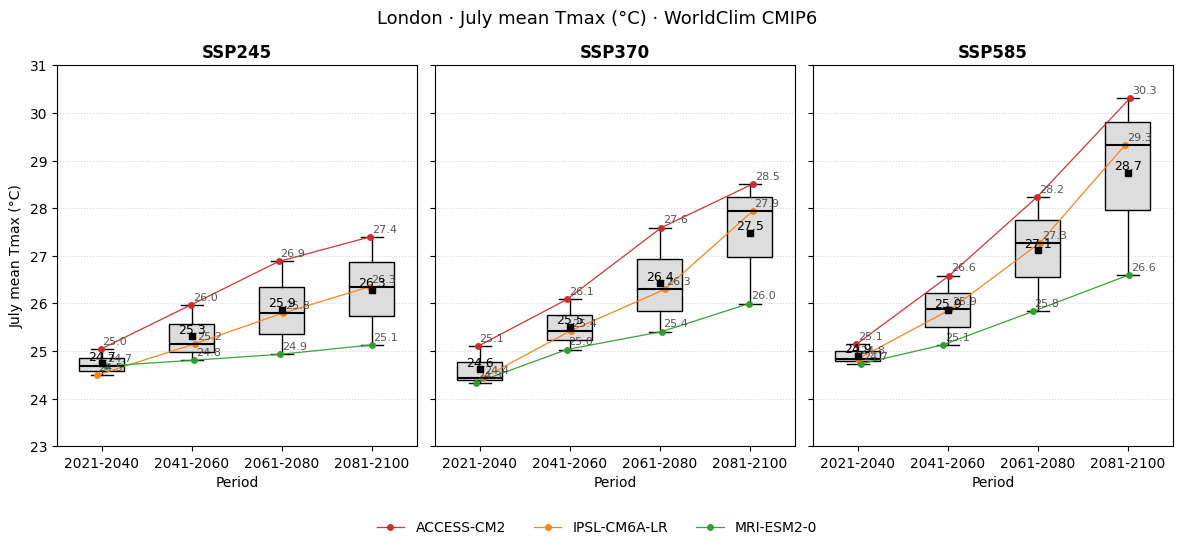

In [ ]:
import math, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_ipcc_style_july(
    df: pd.DataFrame,
    ssp_order=("ssp126","ssp245","ssp370","ssp585"),
    period_order=("2021-2040","2041-2060","2061-2080","2081-2100"),
    title="London · July mean Tmax (°C) · WorldClim CMIP6",
    save_png: Path | None = None,
    model_colors: dict | None = None,
    # mean labels
    mean_label_fmt="{:.1f}",
    mean_marker_kwargs=None,
    mean_text_kwargs=None,
    # NEW: per-model dot labels
    annotate_model_dots=True,
    model_label_fmt="{:.1f}",
    model_text_kwargs=None,
    model_label_dx=0.02,   # x shift for text (in data x units ~ index space)
    model_label_dy=0.05,   # y shift for text (in °C)
):
    """
    Expects df from load_july_means_from_excel(...):
      columns: ['model','ssp','ssp_canon','period','july_tmax_c', ...]
    Adds: legend at bottom; labels the per-period MEAN; and (optional) labels each model dot.
    """
    # filter
    df = df[df["ssp_canon"].isin(ssp_order) & df["period"].isin(period_order)].copy()
    if df.empty:
        raise ValueError("No rows after filtering by SSP and period. Check inputs.")

    # y-scale
    y_min = math.floor(df["july_tmax_c"].min() - 0.5) if df["july_tmax_c"].notna().any() else 0
    y_max = math.ceil(df["july_tmax_c"].max() + 0.5) if df["july_tmax_c"].notna().any() else 1

    # colors per model
    models_all = sorted(df["model"].dropna().unique())
    if model_colors is None:
        cmap = plt.get_cmap("tab20")
        model_colors = {m: cmap(i % 20) for i, m in enumerate(models_all)}
    else:
        cmap = plt.get_cmap("tab20")
        for i, m in enumerate(models_all):
            model_colors.setdefault(m, cmap(i % 20))

    # defaults
    if mean_marker_kwargs is None:
        mean_marker_kwargs = dict(marker="s", color="black", markersize=5, zorder=3)
    if mean_text_kwargs is None:
        mean_text_kwargs = dict(color="black", fontsize=9, ha="center", va="bottom")
    if model_text_kwargs is None:
        model_text_kwargs = dict(color="#444444", fontsize=8, ha="left", va="bottom", alpha=0.9)

    ncols = len(ssp_order)
    fig, axes = plt.subplots(1, ncols, figsize=(4.8*ncols, 5.6), sharey=True, constrained_layout=False)
    if ncols == 1:
        axes = [axes]

    # for bottom legend
    legend_handles, legend_labels = [], []

    for ax, ssp in zip(axes, ssp_order):
        sub = df[df["ssp_canon"] == ssp]
        ax.set_title(ssp.upper(), fontweight="bold")

        xpos = np.arange(len(period_order))
        # box data per period
        data_for_boxes = [sub.loc[sub["period"] == per, "july_tmax_c"].dropna().values for per in period_order]
        ax.boxplot(
            data_for_boxes, positions=xpos, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor="#dddddd", edgecolor="black"),
            medianprops=dict(color="black", linewidth=1.5),
            whiskerprops=dict(color="black"), capprops=dict(color="black")
        )

        # overlay model-colored dots + lines + (optional) labels
        models = sorted(sub["model"].dropna().unique())
        for m in models:
            c = model_colors.get(m, "#333333")
            vals, xs = [], []
            for i, per in enumerate(period_order):
                v = sub.loc[(sub["model"] == m) & (sub["period"] == per), "july_tmax_c"]
                if not v.empty and np.isfinite(v.iloc[0]):
                    xs.append(i + (random.random() - 0.5) * 0.12)
                    vals.append(v.iloc[0])

            if xs:
                ln, = ax.plot(xs, vals, marker="o", linewidth=0.9, markersize=4,
                              alpha=0.95, color=c, label=m)
                if m not in legend_labels:
                    legend_handles.append(ln)
                    legend_labels.append(m)

                # annotate each dot with its value
                if annotate_model_dots:
                    for x_i, y_i in zip(xs, vals):
                        ax.text(x_i + model_label_dx, y_i + model_label_dy,
                                model_label_fmt.format(y_i), **model_text_kwargs)

        # compute and annotate MEAN per period
        for i, per in enumerate(period_order):
            v = sub.loc[sub["period"] == per, "july_tmax_c"].dropna().values
            if v.size:
                mean_val = float(np.mean(v))
                ax.plot([i], [mean_val], **mean_marker_kwargs)
                ax.text(i, mean_val, mean_label_fmt.format(mean_val), **mean_text_kwargs)

        ax.set_xticks(xpos)
        ax.set_xticklabels(period_order, rotation=0)
        ax.set_ylim(y_min, y_max)
        ax.grid(True, axis="y", linestyle=":", alpha=0.5)
        ax.set_xlabel("Period")

    axes[0].set_ylabel("July mean Tmax (°C)")
    fig.suptitle(title, fontsize=13)

    ## subplot adjustments
    # fig.tight_layout(pad=0.1)
    plt.subplots_adjust(bottom=0.2, top=0.88, wspace=0.05) # wspace = gap between columns, hspace = gap between rows
    
    # legend at bottom
    fig.legend(
        legend_handles, legend_labels,
        loc="lower center", ncol=min(6, len(legend_labels)), frameon=False,
        bbox_to_anchor=(0.5, 0.02)
    )

    if save_png:
        save_png = Path(save_png)
        save_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_png, dpi=300, bbox_inches="tight")
        print("Saved figure:", save_png)

    plt.show()




df_july = load_july_means_from_excel(
    xlsx_path=dir_gcm / "clipped" / "stats" / "worldclim_tmax_summary.xlsx",
    var="tmax", stats_col="mean"
)

plot_ipcc_style_july(
    df_july,
    # ssp_order=("ssp126","ssp245","ssp370","ssp585"),
    ssp_order=("ssp245","ssp370","ssp585"),
    period_order=("2021-2040","2041-2060","2061-2080","2081-2100"),
    # title="London · July mean Tmax (°C) · Models colored; mean + per-dot labels",
    save_png=dir_gcm / "figures" / "july_tmax_ipcc_models_labels_mean_models2.png",
    model_colors={
        "EC-Earth3-Veg": "#1f77b4",
        "IPSL-CM6A-LR":  "#ff7f0e",
        "MRI-ESM2-0":    "#2ca02c",
        "ACCESS-CM2":    "#d62728",
        "MIROC6":        "#9467bd",
    },
    model_label_fmt="{:.1f}",   # per-dot labels like 25.3
    model_label_dx=0.02,        # tweak if labels overlap
    model_label_dy=0.06
)


### facet by model

This version facets by model (one panel per model), and within each panel it plots colored lines/points for each SSP across the four periods. Shared y-axis, bottom legend, and optional per-point value labels are included.

Saved figure: E:\GCMs\figures\july_tmax_facet_model_color_ssp.png


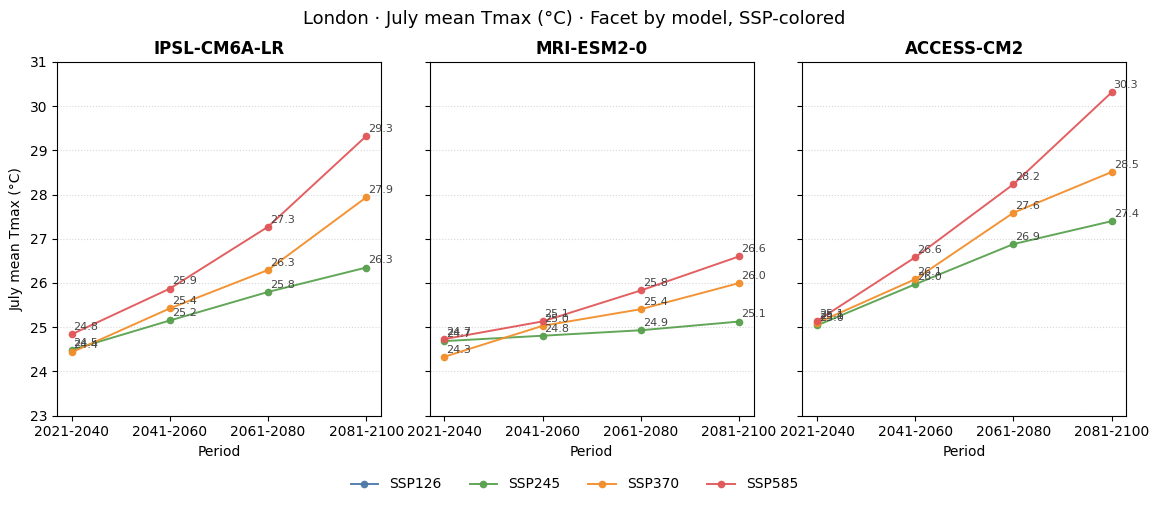

In [ ]:
import math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_ipcc_style_by_model_color_ssp(
    df: pd.DataFrame,
    model_order: tuple | None = None,                    # e.g., ("EC-Earth3-Veg","IPSL-CM6A-LR","MRI-ESM2-0","ACCESS-CM2","MIROC6")
    ssp_order=("ssp126","ssp245","ssp370","ssp585"),
    period_order=("2021-2040","2041-2060","2061-2080","2081-2100"),
    title="London · July mean Tmax (°C) · Facet by model, colored by SSP",
    save_png: Path | None = None,
    ssp_colors: dict | None = None,                     # optional color map per SSP
    annotate_points=True,                                # add numeric labels next to points
    point_label_fmt="{:.1f}",
    point_text_kwargs=None,                              # e.g., dict(fontsize=8, color="#444")
):
    """
    Expects df from load_july_means_from_excel(...), with columns:
      ['model','ssp','ssp_canon','period','period_start','july_tmax_c', ...]
    Facets by MODEL (columns), colors series by SSP, x-axis = period.
    """
    # filter + copy
    df = df[df["ssp_canon"].isin(ssp_order) & df["period"].isin(period_order)].copy()
    if df.empty:
        raise ValueError("No rows after filtering by SSP and period. Check inputs.")

    # determine model order
    models_all = sorted(df["model"].dropna().unique())
    if model_order is None:
        model_order = tuple(models_all)
    else:
        # keep only those present, preserve requested order
        model_order = tuple(m for m in model_order if m in models_all)

    # y limits shared across panels
    y_min = math.floor(df["july_tmax_c"].min() - 0.5)
    y_max = math.ceil(df["july_tmax_c"].max() + 0.5)

    # SSP colors
    if ssp_colors is None:
        # simple distinct mapping
        default_cols = ["#4e79a7", "#f28e2b", "#e15759", "#59a14f", "#b07aa1", "#edc949"]
        ssp_colors = {s: default_cols[i % len(default_cols)] for i, s in enumerate(ssp_order)}
    else:
        # ensure all SSPs have a color
        fallback = ["#4e79a7", "#f28e2b", "#e15759", "#59a14f", "#b07aa1", "#edc949"]
        for i, s in enumerate(ssp_order):
            ssp_colors.setdefault(s, fallback[i % len(fallback)])

    if point_text_kwargs is None:
        point_text_kwargs = dict(color="#444444", fontsize=8, ha="left", va="bottom")

    ncols = len(model_order)
    fig, axes = plt.subplots(1, ncols, figsize=(4.6*ncols, 5.2), sharey=True, constrained_layout=False)
    if ncols == 1:
        axes = [axes]

    legend_handles, legend_labels = [], []

    # x positions by period
    x_idx = np.arange(len(period_order))

    for ax, model in zip(axes, model_order):
        sub_m = df[df["model"] == model]
        ax.set_title(model, fontweight="bold")

        # draw one colored series per SSP across periods
        for ssp in ssp_order:
            sub_ms = sub_m[sub_m["ssp_canon"] == ssp]
            # ensure we place values in period order
            y_vals = []
            for per in period_order:
                v = sub_ms.loc[sub_ms["period"] == per, "july_tmax_c"]
                y_vals.append(float(v.iloc[0]) if not v.empty and np.isfinite(v.iloc[0]) else np.nan)

            # plot line + points
            col = ssp_colors[ssp]
            ln, = ax.plot(x_idx, y_vals, "-o", linewidth=1.4, markersize=4.5, color=col, label=ssp.upper(), alpha=0.95)

            # collect legend handles (first panel only)
            if not legend_labels or ssp.upper() not in legend_labels:
                legend_handles.append(ln)
                legend_labels.append(ssp.upper())

            # annotate each point (optional)
            if annotate_points:
                for xi, yi in zip(x_idx, y_vals):
                    if np.isfinite(yi):
                        ax.text(xi + 0.02, yi + 0.05, point_label_fmt.format(yi), **point_text_kwargs)

        ax.set_xticks(x_idx)
        ax.set_xticklabels(period_order, rotation=0)
        ax.set_ylim(y_min, y_max)
        ax.grid(True, axis="y", linestyle=":", alpha=0.5)
        ax.set_xlabel("Period")

    axes[0].set_ylabel("July mean Tmax (°C)")
    fig.suptitle(title, fontsize=13)

    # Legend at the bottom
    plt.subplots_adjust(bottom=0.2, top=0.88, wspace=0.15)
    fig.legend(
        legend_handles, legend_labels,
        loc="lower center", ncol=min(6, len(legend_labels)), frameon=False,
        bbox_to_anchor=(0.5, 0.03)
    )

    if save_png:
        save_png = Path(save_png)
        save_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_png, dpi=200, bbox_inches="tight")
        print("Saved figure:", save_png)

    plt.show()





plot_ipcc_style_by_model_color_ssp(
    df_july,
    model_order=("EC-Earth3-Veg","IPSL-CM6A-LR","MRI-ESM2-0","ACCESS-CM2","MIROC6"),
    ssp_order=("ssp126","ssp245","ssp370","ssp585"),
    period_order=("2021-2040","2041-2060","2061-2080","2081-2100"),
    title="London · July mean Tmax (°C) · Facet by model, SSP-colored",
    save_png=dir_gcm / "figures" / "july_tmax_facet_model_color_ssp.png",
    ssp_colors={
        "ssp126": "#4e79a7",
        "ssp245": "#59a14f",
        "ssp370": "#f28e2b",
        "ssp585": "#e15759",
    },
    annotate_points=True,
    point_label_fmt="{:.1f}"
)


### pool models

pools all models together, draws side-by-side colored boxplots per SSP for each period (no facets), and optionally overlays jittered dots (one per model value). Legend sits at the bottom.

All expected models present for every (period × SSP).
Saved figure: E:\GCMs\figures\july_tmax_box_by_ssp_checked.png


,period,ssp,n_present,n_expected,missing,extra
0,2021-2040,ssp245,3,3,,
1,2021-2040,ssp370,3,3,,
2,2021-2040,ssp585,3,3,,
3,2041-2060,ssp245,3,3,,
4,2041-2060,ssp370,3,3,,
5,2041-2060,ssp585,3,3,,
6,2061-2080,ssp245,3,3,,
7,2061-2080,ssp370,3,3,,
8,2061-2080,ssp585,3,3,,
9,2081-2100,ssp245,3,3,,


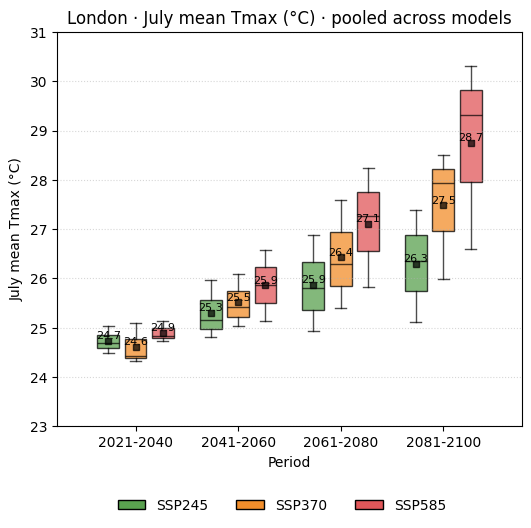

In [ ]:
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_box_by_ssp_no_facet(
    df: pd.DataFrame,
    ssp_order=("ssp126","ssp245","ssp370","ssp585"),
    period_order=("2021-2040","2041-2060","2061-2080","2081-2100"),
    title="London · July mean Tmax (°C) · Pooled models; colored by SSP",
    save_png: Path | None = None,
    ssp_colors=None,
    show_points=True,
    point_alpha=0.6,
    point_size=16,
    annotate_means=True,
    mean_fmt="{:.1f}",
    mean_text_kwargs=None,
    mean_marker_kwargs=None,
    # --- NEW: coverage controls ---
    expected_models: set | None = None,   # pass a set of model names you expect; default = infer from df
    assert_full_coverage: bool = False,   # raise AssertionError if any (period,ssp) missing a model
    verbose: bool = True,                 # print a compact coverage report
):
    """
    Pools all models and draws side-by-side colored boxplots per SSP for each period.
    Also checks model coverage for the jittered dots and warns about missing/duplicate entries.

    Expects df columns (from load_july_means_from_excel):
      ['model','ssp','ssp_canon','period','july_tmax_c', ...]
    """
    # filter & copy
    df = df[df["ssp_canon"].isin(ssp_order) & df["period"].isin(period_order)].copy()
    if df.empty:
        raise ValueError("No rows after filtering by SSP and period. Check inputs.")

    # normalize palettes
    if ssp_colors is None:
        ssp_colors = {"ssp126": "#4e79a7", 
                      "ssp245": "#59a14f", 
                      "ssp370": "#f28e2b", 
                      "ssp585": "#e15759"}
    fallback = ["#4e79a7","#59a14f","#f28e2b","#e15759","#b07aa1","#edc949"]
    for i, s in enumerate(ssp_order):
        ssp_colors.setdefault(s, fallback[i % len(fallback)])

    # y scale
    y_min = math.floor(df["july_tmax_c"].min() - 0.5)
    y_max = math.ceil(df["july_tmax_c"].max() + 0.5)

    # infer expected models if not supplied
    if expected_models is None:
        expected_models = set(df["model"].dropna().unique())

    # ---- NEW: collapse duplicates to one value per (model, ssp, period) ----
    # If there are multiple rows for a model in the same (ssp, period), take the mean to plot one dot.
    df_one = (df.groupby(["model","ssp_canon","period"], as_index=False)["july_tmax_c"]
                .mean())

    # ---- NEW: coverage report ----
    coverage_rows = []
    for per in period_order:
        for ssp in ssp_order:
            sub = df_one[(df_one["period"]==per) & (df_one["ssp_canon"]==ssp)]
            present = set(sub["model"])
            missing = sorted(expected_models - present)
            extra   = sorted(present - expected_models)
            coverage_rows.append({
                "period": per,
                "ssp": ssp,
                "n_present": len(present),
                "n_expected": len(expected_models),
                "missing": ", ".join(missing) if missing else "",
                "extra": ", ".join(extra) if extra else ""
            })
    coverage_df = pd.DataFrame(coverage_rows)

    if verbose:
        # Only print rows where something is missing or extra
        prob = coverage_df[(coverage_df["missing"]!="") | (coverage_df["extra"]!="")]
        if not prob.empty:
            print("Coverage warnings (by period × SSP):")
            print(prob.to_string(index=False))
        else:
            print("All expected models present for every (period × SSP).")

    if assert_full_coverage:
        bad = coverage_df[coverage_df["n_present"] < coverage_df["n_expected"]]
        if not bad.empty:
            raise AssertionError("Missing models detected:\n" + bad.to_string(index=False))

    # ---- build boxplot data from original df (not collapsed), but overlay dots from df_one ----
    data = {}
    for per in period_order:
        data[per] = {}
        for ssp in ssp_order:
            vals = df.loc[(df["period"] == per) & (df["ssp_canon"] == ssp), "july_tmax_c"].dropna().values
            data[per][ssp] = vals

    n_periods = len(period_order)
    n_ssp     = len(ssp_order)
    group_width = 0.8
    box_w = group_width / n_ssp
    x_groups = np.arange(n_periods)

    fig, ax = plt.subplots(figsize=(min(6, 1.8*n_periods*n_ssp), 5.8))

    # positions/colors/arrays for boxes
    boxes_positions, boxes_colors, boxes_arrays = [], [], []
    for gi, per in enumerate(period_order):
        for si, ssp in enumerate(ssp_order):
            x = x_groups[gi] - group_width/2 + (si + 0.5)*box_w
            boxes_positions.append(x)
            boxes_colors.append(ssp_colors[ssp])
            boxes_arrays.append(data[per][ssp])

    bp = ax.boxplot(
        boxes_arrays, positions=boxes_positions, widths=box_w*0.8, patch_artist=True,
        showfliers=False,
        medianprops=dict(color="black", linewidth=1, alpha=0.7),
        whiskerprops=dict(color="black", alpha=0.7),
        capprops=dict(color="black", alpha=0.7)
    ) 
    # ↓ put boxes underneath points + add slight transparency for clarity
    for patch, col in zip(bp["boxes"], boxes_colors): # keep your assigned color
        patch.set_facecolor(col)
        patch.set_edgecolor("black") 
        patch.set_alpha(0.75)                       # optional
        patch.set_zorder(1)                         # << lower than points

    # overlay jittered ONE-DOT-PER-MODEL from df_one, and confirm inclusion
    if show_points:
        rng = np.random.default_rng(42)
        for gi, per in enumerate(period_order):
            for si, ssp in enumerate(ssp_order):
                sub = df_one[(df_one["period"]==per) & (df_one["ssp_canon"]==ssp)].copy()
                # stable order by model name for reproducible jitter
                sub = sub.sort_values("model")
                vals = sub["july_tmax_c"].to_numpy()
                n = vals.size
                if n:
                    x_center = x_groups[gi] - group_width/2 + (si + 0.5)*box_w
                    xs = x_center + (rng.random(n) - 0.5) * (box_w*0.7)
                    col = ssp_colors[ssp]
                    ax.scatter(xs, vals, s=point_size, 
                               alpha=point_alpha, color=col, 
                               zorder=5,               # << put points on top
                               clip_on=False,          # optional: show dots even at panel edge
                               edgecolors="gray")      # edgecolors="none"

    # annotate means per box (optional)
    if mean_text_kwargs is None:
        mean_text_kwargs = dict(color="black", fontsize=8, ha="center", va="bottom")
    if mean_marker_kwargs is None:
        mean_marker_kwargs = dict(marker="s", color="black", alpha=0.7, markersize=5, zorder=3)

    if annotate_means:
        for pos, arr in zip(boxes_positions, boxes_arrays):
            if len(arr):
                mu = float(np.mean(arr))
                ax.plot([pos], [mu], **mean_marker_kwargs)
                ax.text(pos, mu, mean_fmt.format(mu), **mean_text_kwargs)

    # axes/ticks
    ax.set_xticks(x_groups)
    ax.set_xticklabels(period_order, rotation=0)
    ax.set_xlabel("Period")
    ax.set_ylabel("July mean Tmax (°C)")
    ax.set_ylim(y_min, y_max)
    ax.grid(True, axis="y", linestyle=":", alpha=0.5)
    ax.set_title(title)

    # legend
    handles = [Patch(facecolor=ssp_colors[s], edgecolor="black", label=s.upper()) for s in ssp_order]
    plt.subplots_adjust(bottom=0.22, top=0.9)
    fig.legend(handles, [s.upper() for s in ssp_order],
               loc="lower center", ncol=min(6, len(ssp_order)), frameon=False, bbox_to_anchor=(0.5, 0.05))

    if save_png:
        save_png = Path(save_png)
        save_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_png, dpi=200, bbox_inches="tight")
        print("Saved figure:", save_png)

    # return a small coverage report in case you want to inspect programmatically
    return coverage_df


expected = {"IPSL-CM6A-LR","MRI-ESM2-0","ACCESS-CM2"}  # edit to your set


# ssp_order=("ssp126","ssp245","ssp370","ssp585"),
# period_order=("2021-2040","2041-2060","2061-2080","2081-2100")

# ssp_order=("ssp245","ssp370","ssp585"),
# period_order=("2021-2040","2041-2060","2061-2080"),

coverage = plot_box_by_ssp_no_facet(
    df_july,
    ssp_order=("ssp245","ssp370","ssp585"),
    period_order=("2021-2040","2041-2060","2061-2080","2081-2100"),
    title="London · July mean Tmax (°C) · pooled across models",
    save_png=dir_gcm / "figures" / "july_tmax_box_by_ssp_checked.png",
    show_points=False,          # turn off if cluttered
    annotate_means=True,       # labels for the mean per SSP×period
    expected_models=expected,
    assert_full_coverage=False,   # set True to hard-fail if any model missing
    verbose=True
)

# Review coverage table (optional)
coverage